# Data Science - Course Project

### Predicting NBA Salaries based on performance.

The average salaries of NBA players are 5 million USD, while the median are 2.5 million USD. The Salaries of the top basketball players of this planet have piqued the interest of many, statisticians and manager alike.

However, for the NBA team managers, this is a critical factor as the players of the team can make the difference between championship ring and early summer break. The players are also an important factor whether the team can earn profit from game tickets and merchandise.

More importantly, NBA enforces a salary cap on each team, to prevent all the superstar to gather one team.

So, every free agent sign and trades will determine the performance of the team, and also the bottom line of the business. How can we ensure that the player are worth it?

In this project, we will try to explore the NBA data gathered from NBA and ESPN website and try to predict the salaries of the NBA players.


## Data set

We gathered the performance statistic of each NBA players over 2012 to 2016 (4 season total), and then also gathered the Salary of the players in this 4 season.

The performance including basic statistic, such as points and rebound, advanced statistic, such as PIE, offensive ratings and plus/minus.

The salaries are also adjusted for inflation.


### Presentation

In the final week of class, you will give a 5-7 minute presentation summarizing your project. The presentation should target a non­-technical audience - it's a chance to practice the highly sought-after communication skills that data scientists need. It will be appropriate to have an accompanying slide deck.

What to cover in your presentation:

* Overview of problem and hypotheses
* Overview of data
* Appropriate visualizations
* Modeling techniques used and why
* Your findings, and how they're actionable
* Your implementation plan, and any hurdles

Your presentation should be engaging, clear, and informative, describing the project, approach, and conclusions, and be suitable for a non­-technical audience.


In [1]:
# Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols
from numpy import log

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RandomizedLasso

from collections import defaultdict
from sklearn.cross_validation import train_test_split

from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from operator import add

In [54]:
# data
DATA_FOLDER = 'project/'
df = pd.read_csv(DATA_FOLDER+'NBA_data.csv')

df_try = df.copy()

# Cleaning
del df_try["Player"]
del df_try["TEAM"]
del df_try["College"]
del df_try["Country"]

df_try["OffRtg"] = df_try["OffRtg"] - 100
df_try["DefRtg"] = df_try["DefRtg"] - 100

# Delete redundant stuffs
del df_try["GP"]
del df_try["MIN"]

df_try2 = df_try.copy()

# EDA

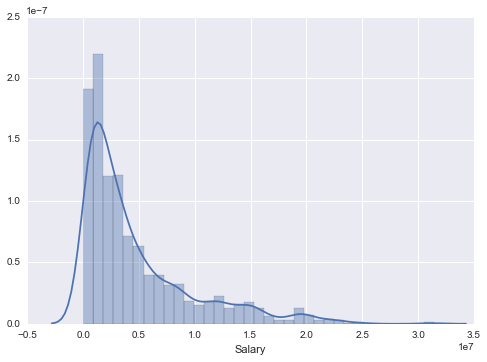

In [3]:
ax = sns.distplot(df_try["Salary"])

In [4]:
print "Mean \t",df_try["Salary"].mean()
print "Median \t",df_try["Salary"].median()

Mean 	4726011.20386
Median 	2896561.958


The long tail also means that most player are underpaid, while there are a handful of super star who commands high salaries (over 15M)

/home/vagrant/.anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


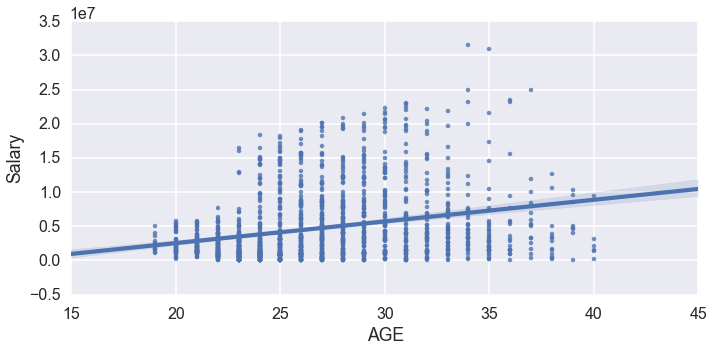

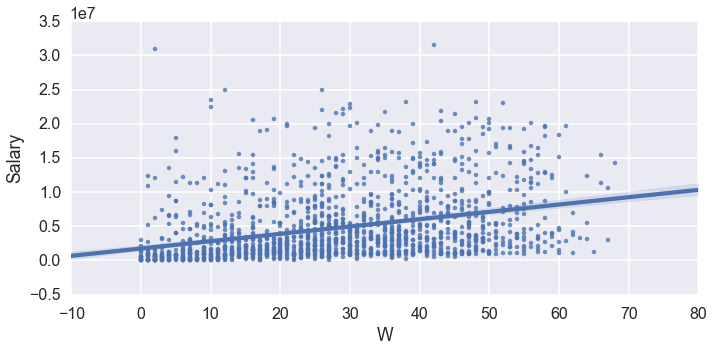

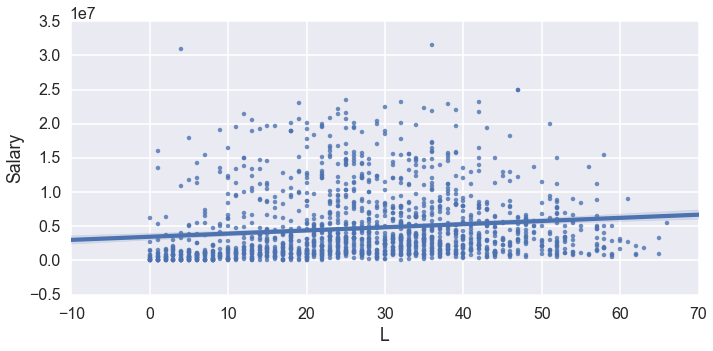

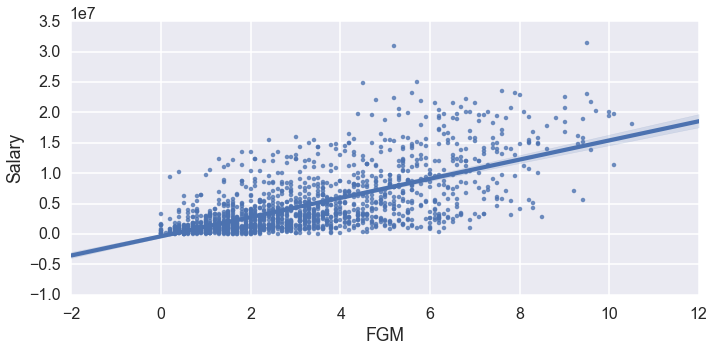

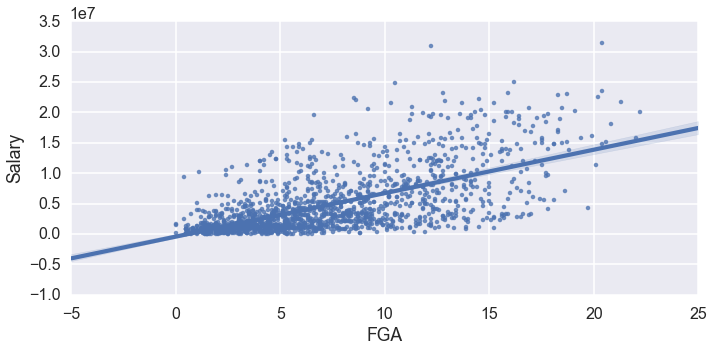

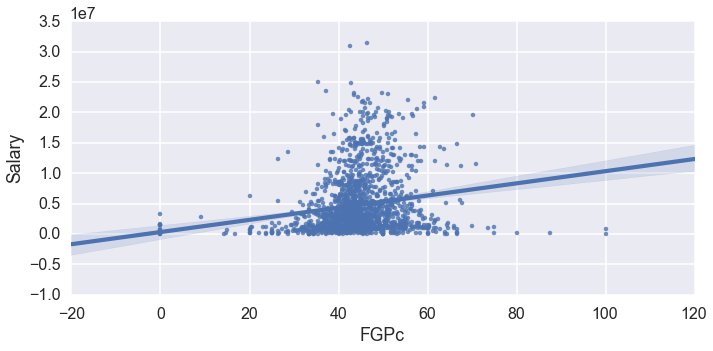

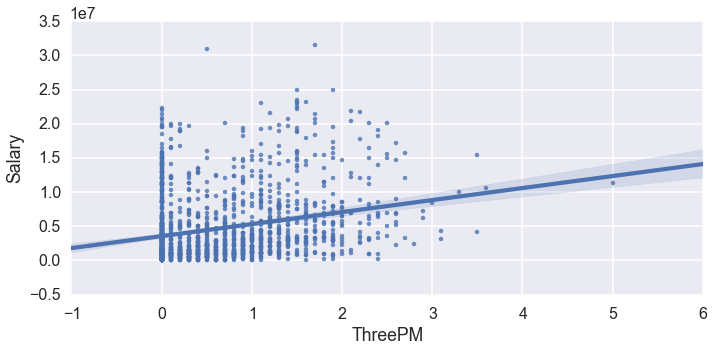

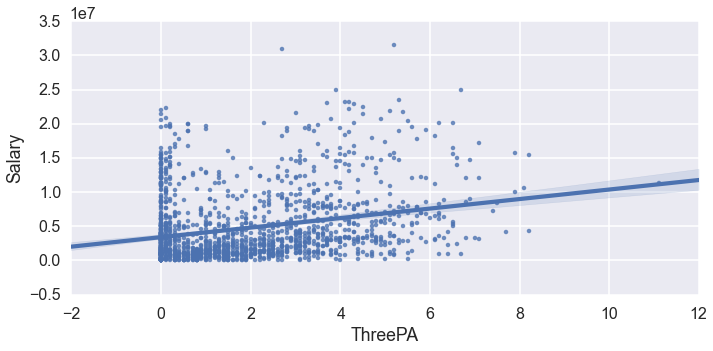

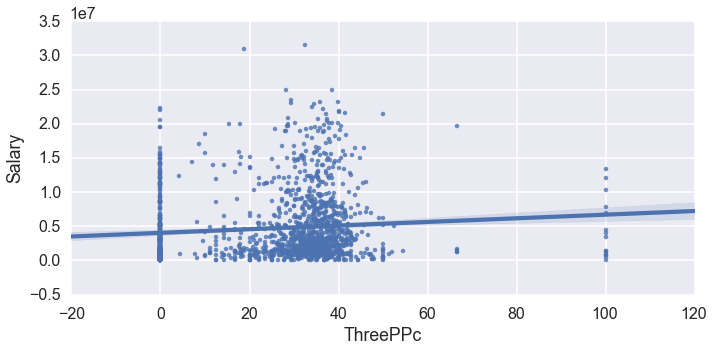

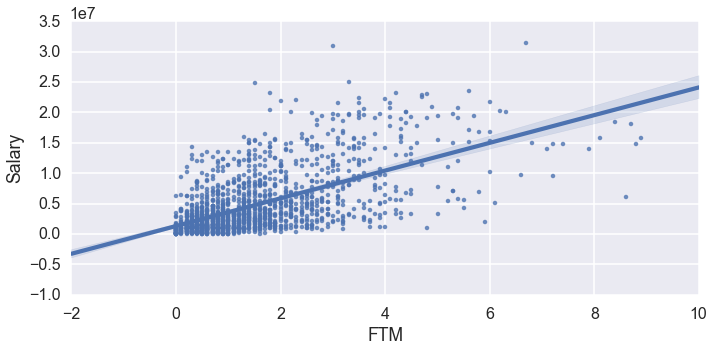

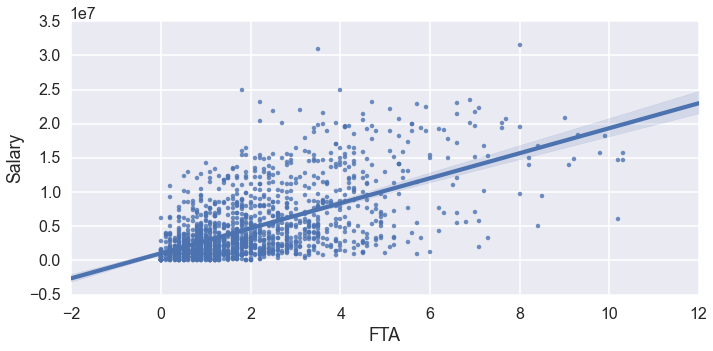

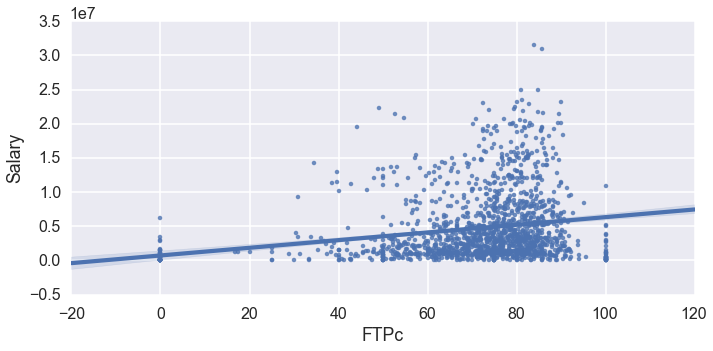

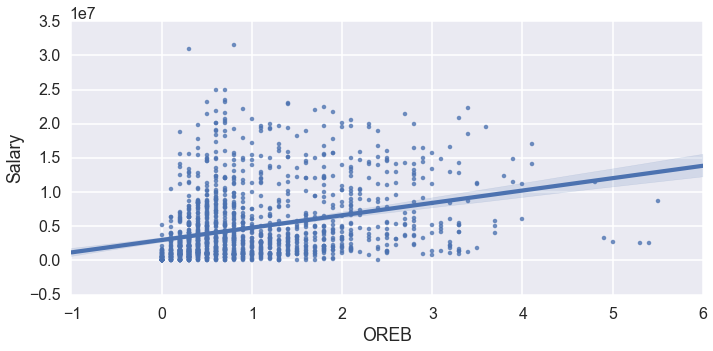

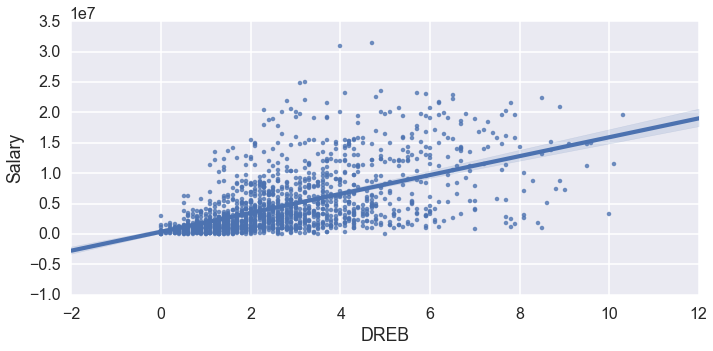

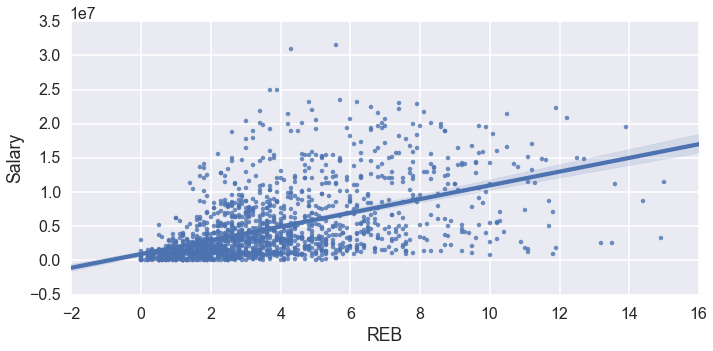

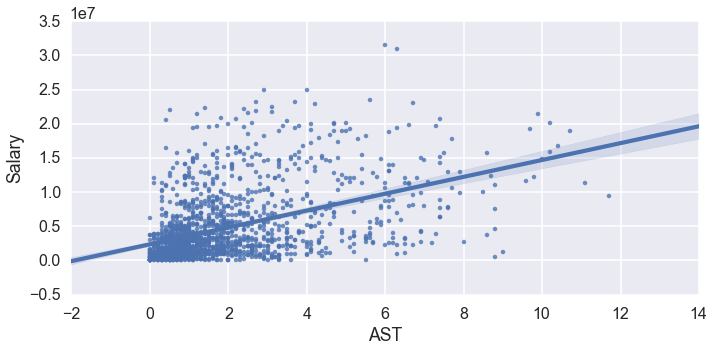

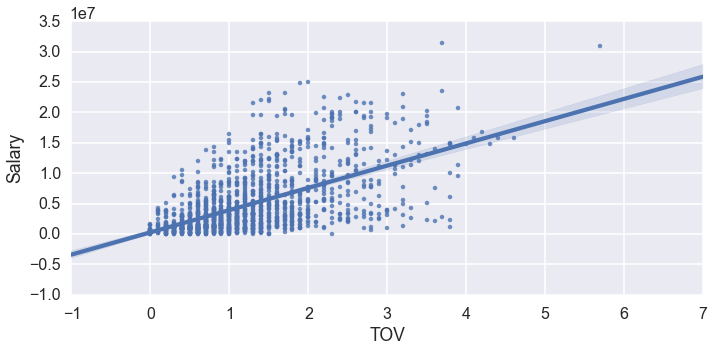

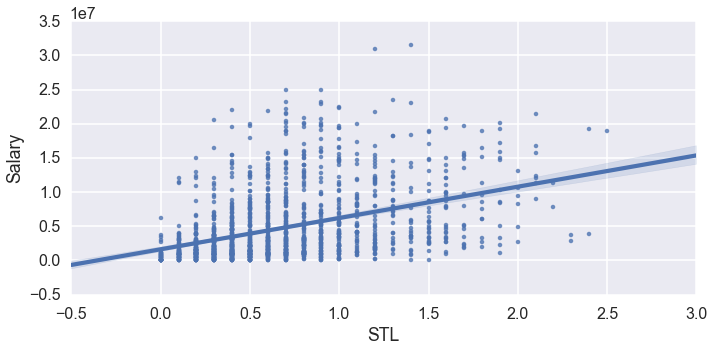

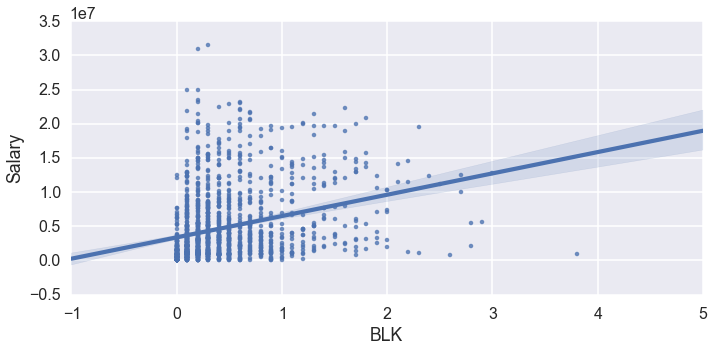

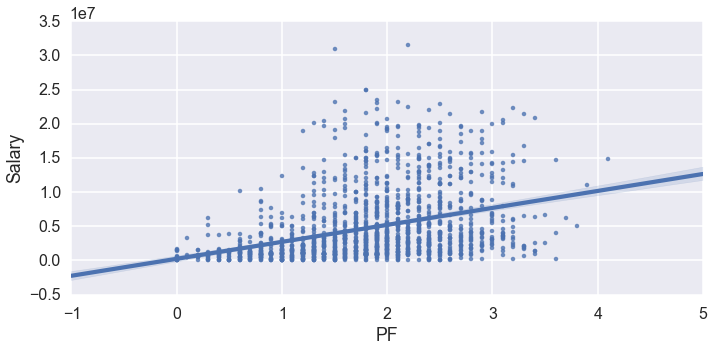

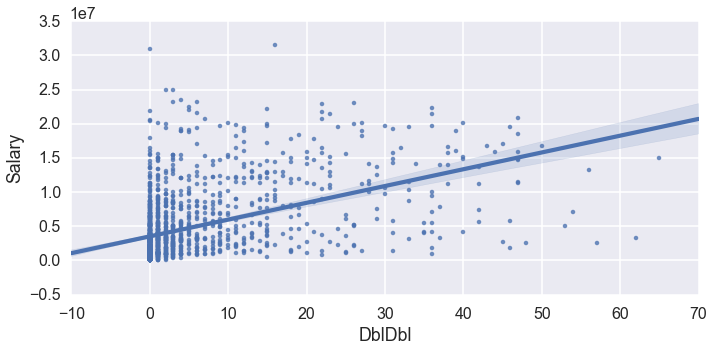

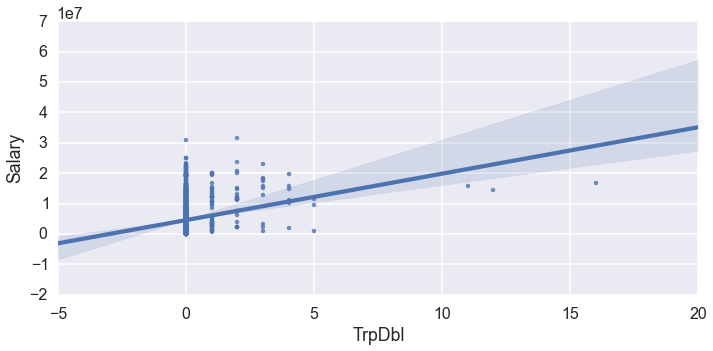

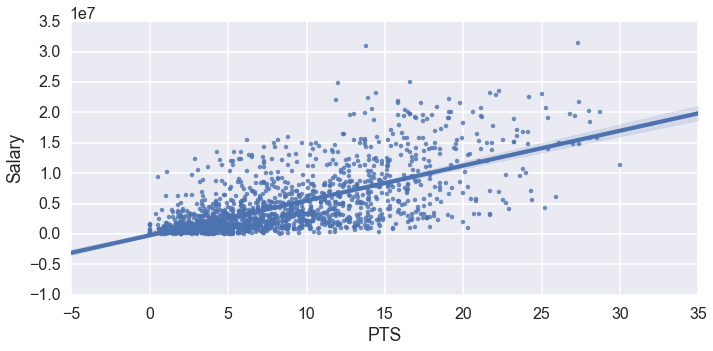

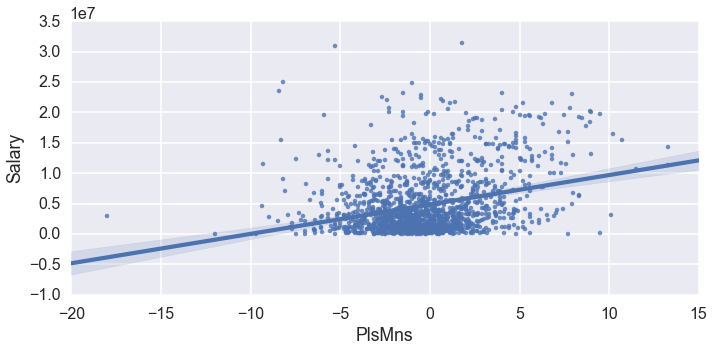

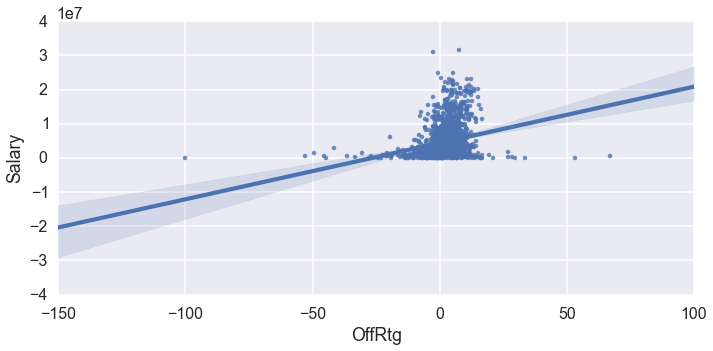

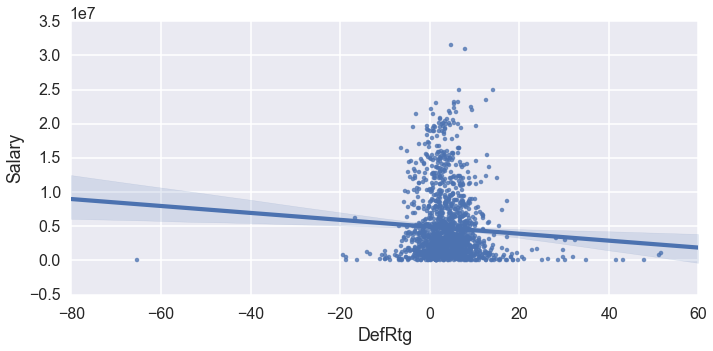

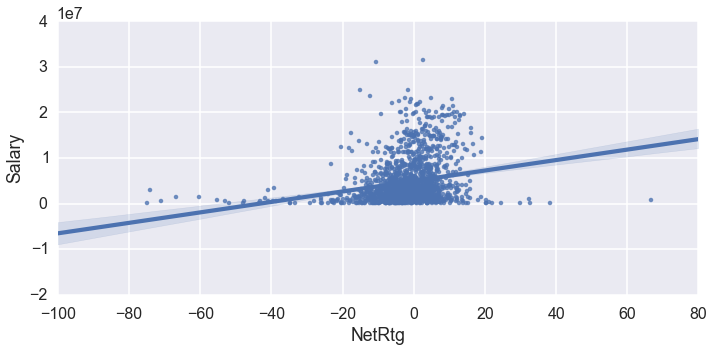

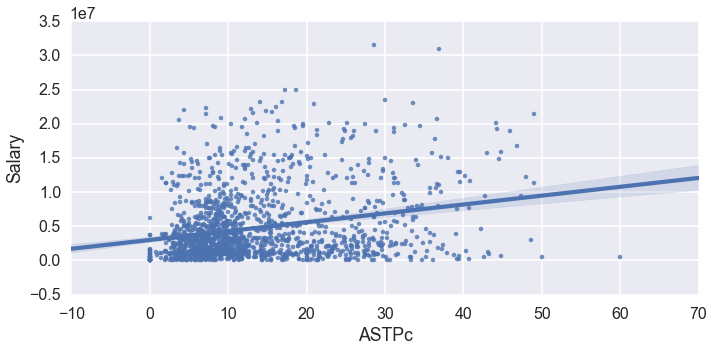

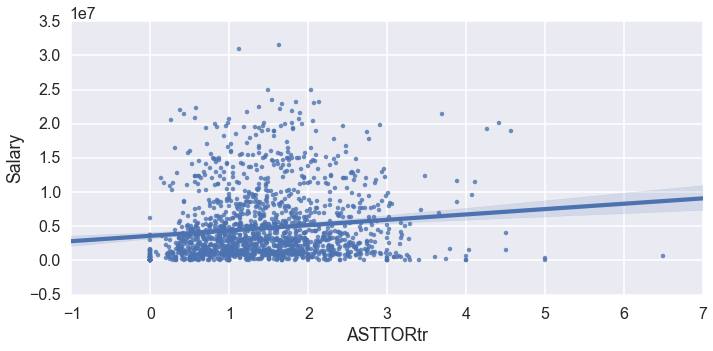

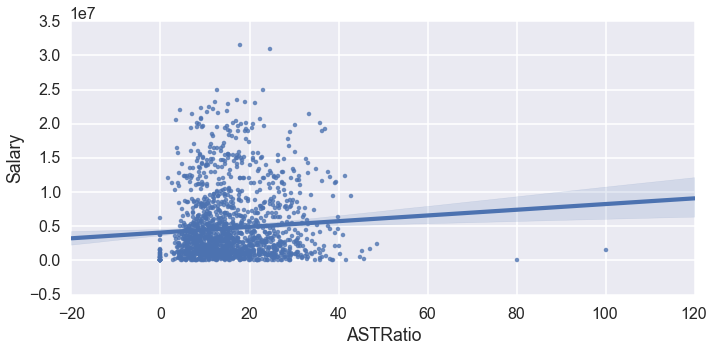

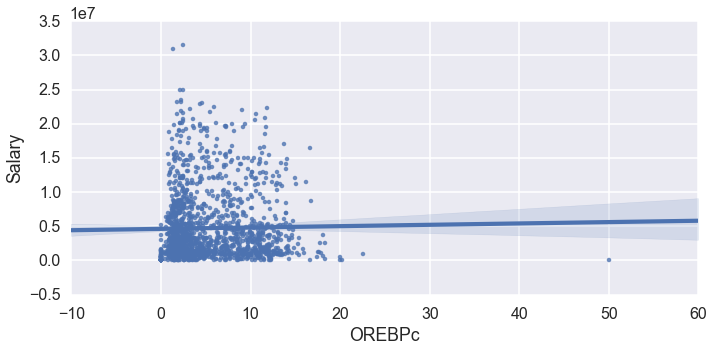

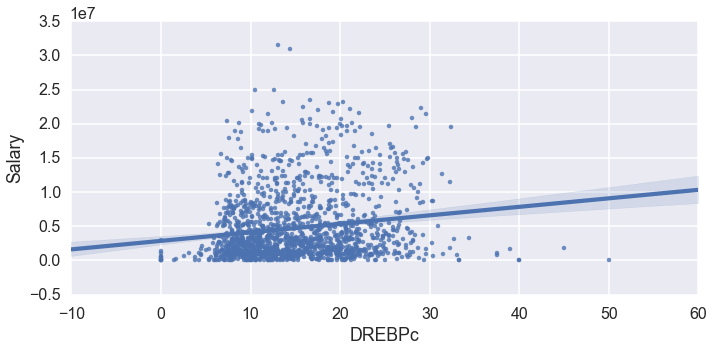

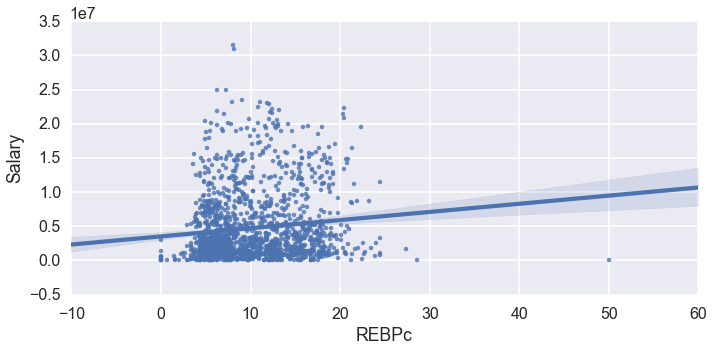

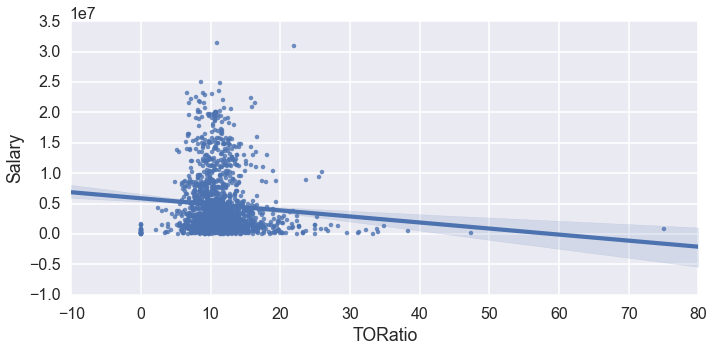

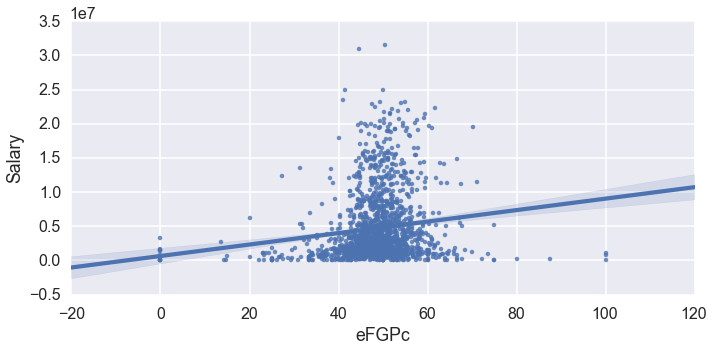

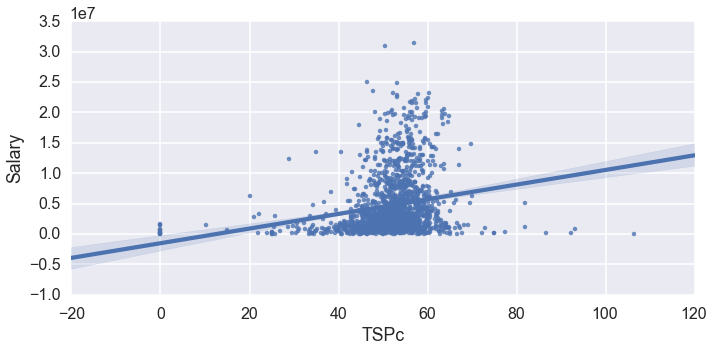

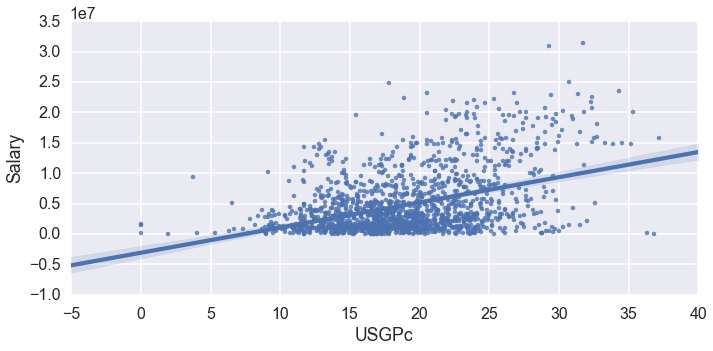

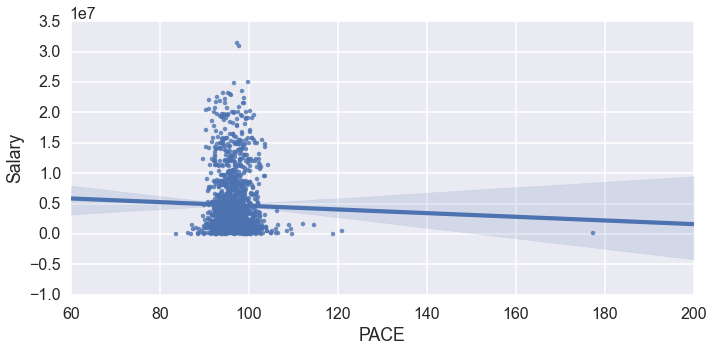

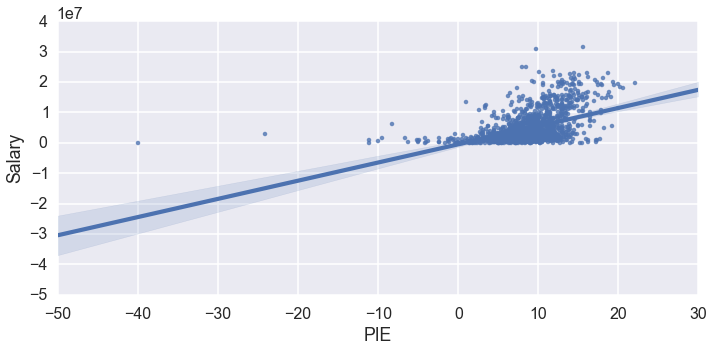

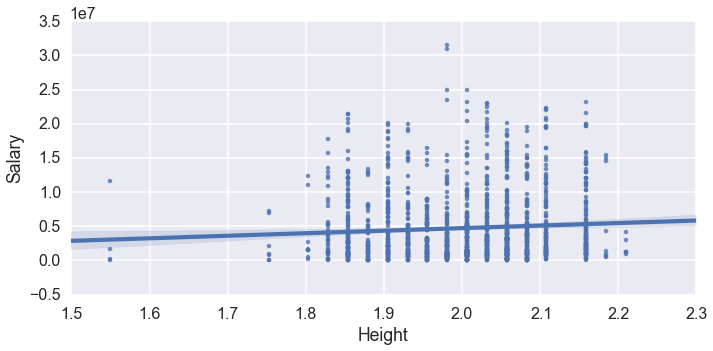

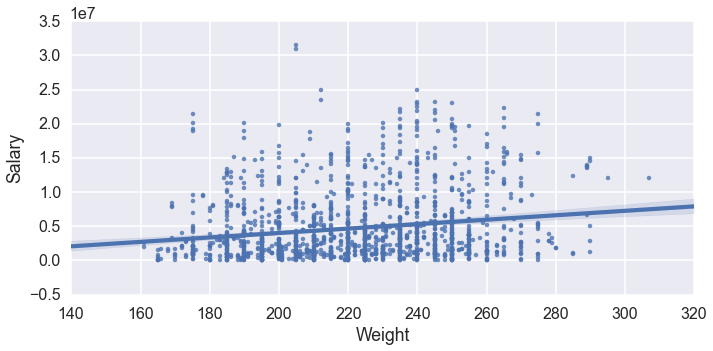

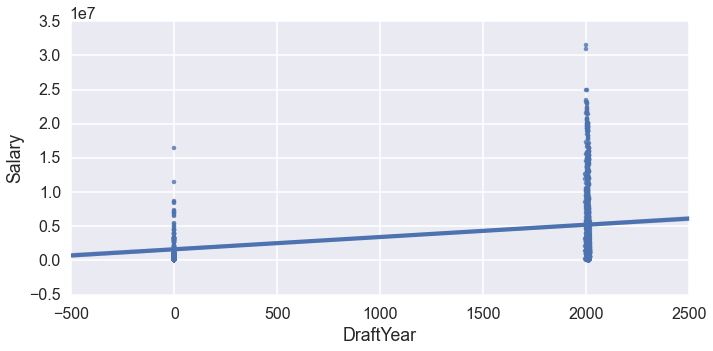

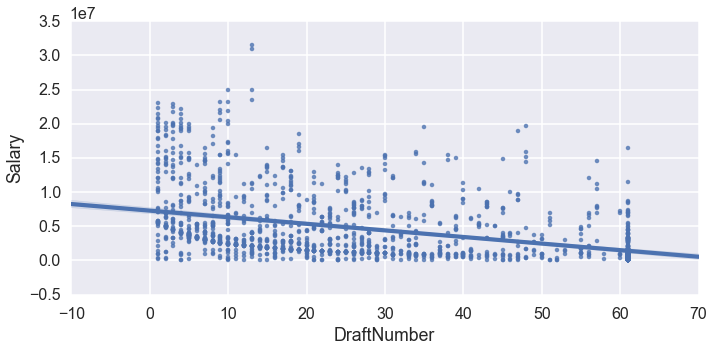

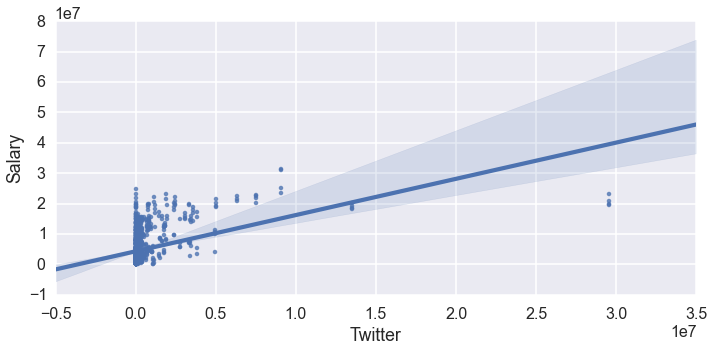

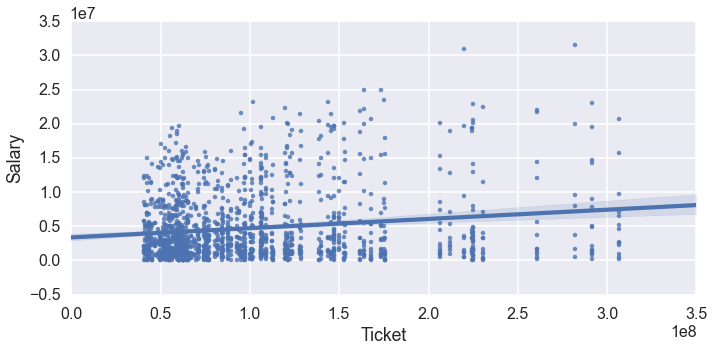

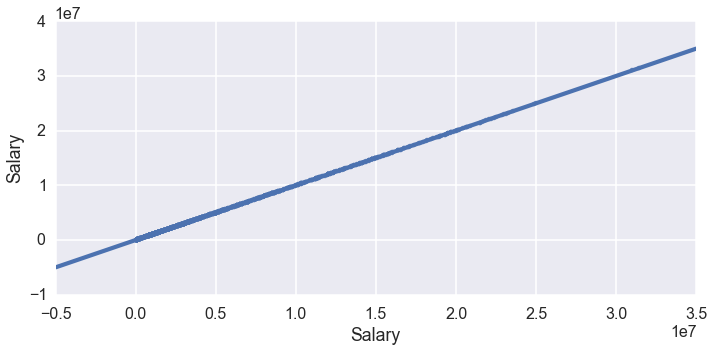

In [5]:
for col in df_try:
    with sns.plotting_context(context='poster'):
        sns.lmplot(col, "Salary", df_try, aspect=2);

Ugh ... nothing to be found...., Let's find our base classifier's score

In [6]:
df_base = df_try.copy()
X = df_base.ix[:,:-3]
Y = df_base.ix[:,-1]

clf =  LinearRegression(fit_intercept=True, normalize=False, copy_X=True)
clf.fit(X,Y)
print clf.score(X,Y)

df_change = df_try.copy()

result = clf.predict(X)

0.596219870842


Correlation?

In [7]:
for xidx,tup in enumerate(df_try):
    column = tup
    for yidx,tup in enumerate(df_try):
        if yidx < xidx:
            continue
        row = tup
        corr = np.corrcoef(df_try[row],df_try[column])[0][1]
        if (abs(corr) > 0.7) & (row != column):
            print row + " " + column + " " + str(corr)
            
print ""

FGA FGM 0.977530812948
FTM FGM 0.843771564316
FTA FGM 0.834563049108
TOV FGM 0.808157139185
PTS FGM 0.986780052383
FTM FGA 0.84079263917
FTA FGA 0.813912295495
TOV FGA 0.828337077757
PTS FGA 0.981273365462
USGPc FGA 0.708611554255
eFGPc FGPc 0.892398161649
TSPc FGPc 0.858055956952
ThreePA ThreePM 0.983800812972
FTA FTM 0.977523336492
TOV FTM 0.783060974876
PTS FTM 0.897093613516
TOV FTA 0.780404689084
PTS FTA 0.874735607756
DREB OREB 0.768051414522
REB OREB 0.888688117893
OREBPc OREB 0.751354608495
REBPc OREB 0.736902826208
REB DREB 0.975900850051
DblDbl DREB 0.793386587403
BLK REB 0.710860161153
DblDbl REB 0.79347110188
TOV AST 0.826335474352
STL AST 0.705060955778
ASTPc AST 0.847189803924
STL TOV 0.713547978858
PTS TOV 0.82332267013
NetRtg PlsMns 0.767976104487
NetRtg OffRtg 0.785347563096
ASTRatio ASTPc 0.813280670725
ASTRatio ASTTORtr 0.748741881766
REBPc OREBPc 0.845630462328
REBPc DREBPc 0.926005808678
Weight REBPc 0.705803075034
TSPc eFGPc 0.9564306603
DraftNumber DraftYear -0.7

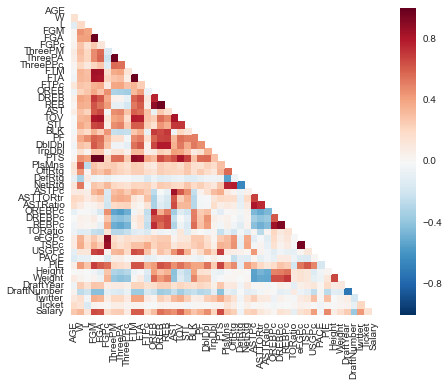

In [8]:
corr = df_try.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True)

Too much correaltion and Too much features

So we need to use PCA and drop the less important one while retaining some information.
We can see that some features are super highly related, such as Field goals attempt/made, points .etc. Because all of them are talking about scoring.

Thus we should try to do pca in similar features to remove correlation and reduce the number of features.

Note that, by nature, some not that related statistic might still have high correlation.
generally, points, rebound and assist is very common to be correlated. (those are the common stats in triple-double/double-double.

Other can be block and rebound, because if a player block another player and get the ball (quite common), he will be credited a block and rebound. (also, tall players/centers/PF usually have high stats in this 2 area) but we will not try to combine them (because, well, it is obvious that block and rebs are different things) 


# Feature Engineering

In [60]:
# Shooting related
df_normShoot = pd.DataFrame()
df_normShoot["FGA"] = df_try["FGA"]
df_normShoot["FGM"] = df_try["FGM"] 
df_normShoot["FGPc"] = df_try["FGPc"]
df_normShoot["FTM"] = df_try["FTM"]
df_normShoot["FTA"] = df_try["FTA"]
df_normShoot["FTPc"] = df_try["FTPc"]
df_normShoot["ThreePA"] = df_try["ThreePA"]
df_normShoot["ThreePM"] = df_try["ThreePM"]
df_normShoot["ThreePPc"] = df_try["ThreePPc"]
df_normShoot["eFGPc"] = df_try["eFGPc"]
df_normShoot["TSPc"] = df_try["TSPc"] 
df_normShoot["PTS"] = df_try["PTS"]


df_normShoot = (df_normShoot - df_normShoot.mean()) / df_normShoot.std()

pcaSht = PCA()
pcaSht.fit(df_normShoot)

labels = ['pc'+ str(pc) for pc in range(0,12)]
df_pca = pd.DataFrame(pcaSht.transform(df_normShoot), columns=labels)

# var = pcaSht.explained_variance_ratio_ / max(pcaSht.explained_variance_)
# plt.plot(var);

del df_try["FGA"]
del df_try["FGM"] 
del df_try["FTM"]
del df_try["FTA"]
del df_try["PTS"]
del df_try["ThreePA"]
del df_try["ThreePM"]
del df_try["ThreePPc"]
del df_try["eFGPc"]
del df_try["TSPc"]
del df_try["FTPc"]
del df_try["FGPc"]

df_try["ShootPC0"] = df_pca["pc0"]
df_try["ShootPC1"] = df_pca["pc1"]
df_try["ShootPC2"] = df_pca["pc2"]
df_try["ShootPC3"] = df_pca["pc3"]
df_try["ShootPC4"] = df_pca["pc4"]
df_try["ShootPC5"] = df_pca["pc5"]
df_try["ShootPC6"] = df_pca["pc6"]

In [61]:
# Rebounding related
df_normReb = pd.DataFrame()
df_normReb["OREB"] = df_try["OREB"]
df_normReb["DREB"] = df_try["DREB"] 
df_normReb["OREBPc"] = df_try["OREBPc"]
df_normReb["DREBPc"] = df_try["DREBPc"]
df_normReb["REBPc"] = df_try["REBPc"]
df_normReb["REB"] = df_try["REB"]

df_normReb = (df_normReb - df_normReb.mean()) / df_normReb.std()

pcaReb = PCA()
pcaReb.fit(df_normReb)

labels = ['pc'+ str(pc) for pc in range(0,6)]
df_pca = pd.DataFrame(pcaReb.transform(df_normReb), columns=labels)

del df_try["OREB"]
del df_try["DREB"] 
del df_try["OREBPc"]
del df_try["DREBPc"]
del df_try["REBPc"]
del df_try["REB"]

df_try["RebPC0"] = df_pca["pc0"]
df_try["RebPC1"] = df_pca["pc1"]
df_try["RebPC2"] = df_pca["pc2"]
df_try["RebPC3"] = df_pca["pc3"]

In [62]:
# Passing related
df_normPss = pd.DataFrame()
df_normPss["AST"] = df_try["AST"]
df_normPss["TOV"] = df_try["TOV"] 
df_normPss["ASTPc"] = df_try["ASTPc"]
df_normPss["ASTRatio"] = df_try["ASTRatio"]
df_normPss["ASTTORtr"] = df_try["ASTTORtr"]
df_normPss["TORatio"] = df_try["TORatio"]

df_normPss = (df_normPss - df_normPss.mean()) / df_normPss.std()

pcaPss = PCA()
pcaPss.fit(df_normPss)

labels = ['pc'+ str(pc) for pc in range(0,6)]
df_pca = pd.DataFrame(pcaPss.transform(df_normPss), columns=labels)

del df_try["AST"]
del df_try["TOV"] 
del df_try["ASTPc"]
del df_try["ASTRatio"]
del df_try["ASTTORtr"]
del df_try["TORatio"]

df_try["PssPC0"] = df_pca["pc0"]
df_try["PssPC1"] = df_pca["pc1"]
df_try["PssPC2"] = df_pca["pc2"]
df_try["PssPC3"] = df_pca["pc3"]

In [63]:
# Rating related
df_normRat = pd.DataFrame()
df_normRat["NetRtg"] = df_try["NetRtg"]
df_normRat["OffRtg"] = df_try["OffRtg"] 
df_normRat["DefRtg"] = df_try["DefRtg"]
df_normRat["PlsMns"] = df_try["PlsMns"]

df_normRat = (df_normRat - df_normRat.mean()) / df_normRat.std()

pcaRat = PCA()
pcaRat.fit(df_normRat)

labels = ['pc'+ str(pc) for pc in range(0,4)]
df_pca = pd.DataFrame(pcaRat.transform(df_normRat), columns=labels)

del df_try["NetRtg"]
del df_try["OffRtg"] 
del df_try["DefRtg"]
del df_try["PlsMns"]

df_try["RatPC0"] = df_pca["pc0"]
df_try["RatPC1"] = df_pca["pc1"]
df_try["RatPC2"] = df_pca["pc2"]

In [64]:
#  put them in the back
temp = df_try["Salary"]
temp2 = df_try["Twitter"]
temp3 = df_try["Ticket"]

del df_try["Ticket"]
del df_try["Twitter"]
del df_try["Salary"]

df_try["Ticket"] = temp3
df_try["Twitter"] = temp2
df_try["Salary"] = temp

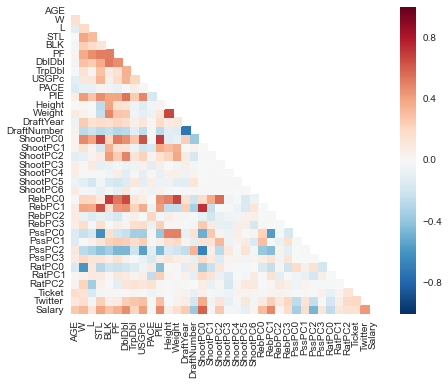

In [14]:
corr = df_try.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True)

In [15]:
df_base = df_try.copy()
X = df_base.ix[:,:-3]
Y = df_base.ix[:,-1]

clf =  LinearRegression(fit_intercept=True, normalize=False, copy_X=True)
clf.fit(X,Y)
print clf.score(X,Y)

df_change = df_try.copy()

result = clf.predict(X)

0.591124493558


a information reduction (rsquare) of 0.005
but reduced feature by 11, not too bad :)

Note that there are some few features that still have high correlation.
but this is not due to their similarity, is that just they sometimes appear together in big plays.

For example, rebound and points (and also assist). Many stars have high stats in this 3, in fact this 3 are the most commonly used to reach double-double or triple double.

Blocks and rebound go together, this is because those 2 are quite common in tall player. when you block and grabbed the ball, you are creditted a block and a rebound (not all the time, it is more common that the ball is swatted out of bounds, or someone get the rebound). hence the moderate collinearity.

But we can't combine/remove them, they are fundamentally different.

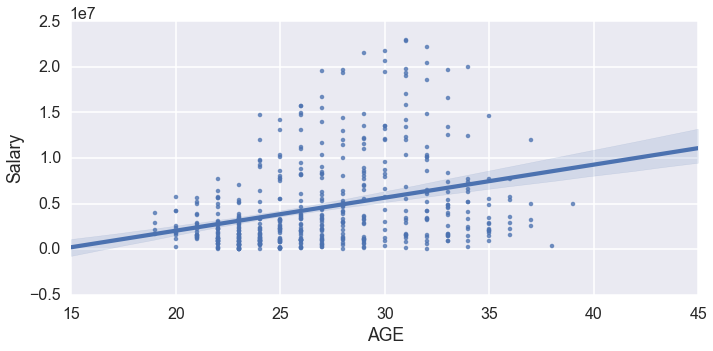

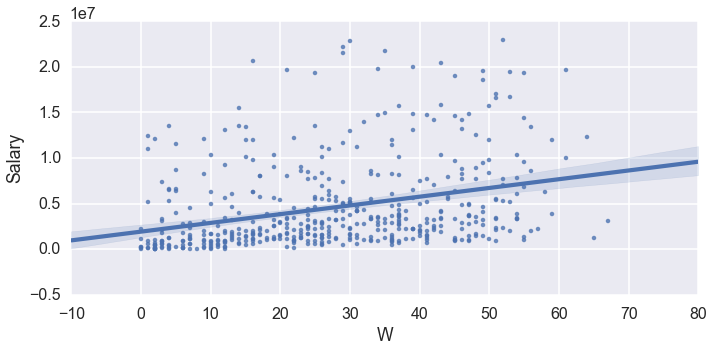

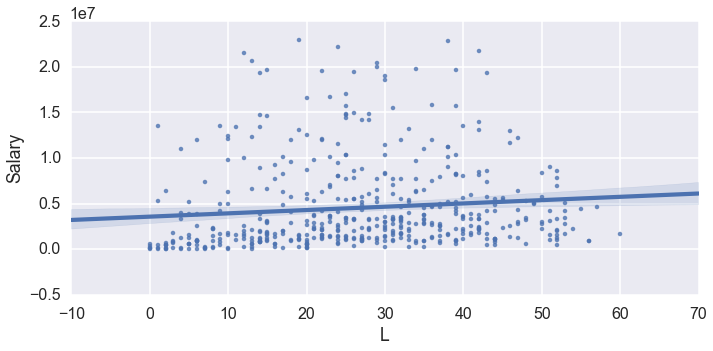

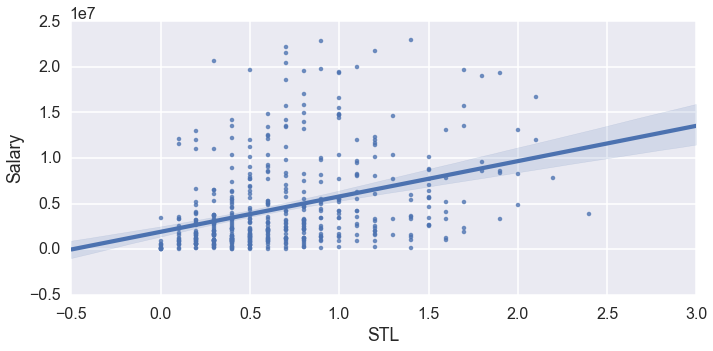

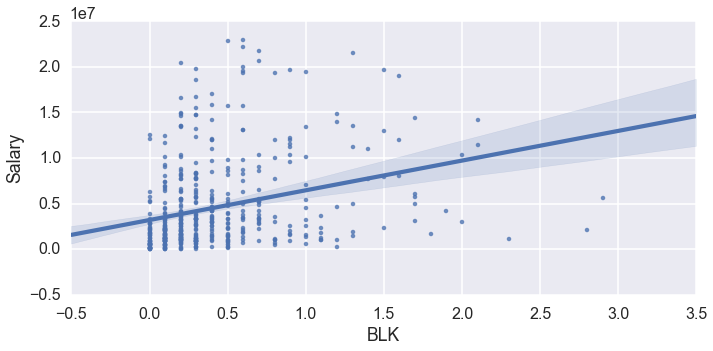

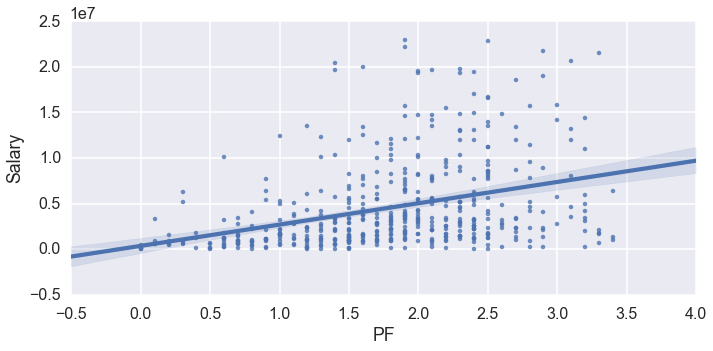

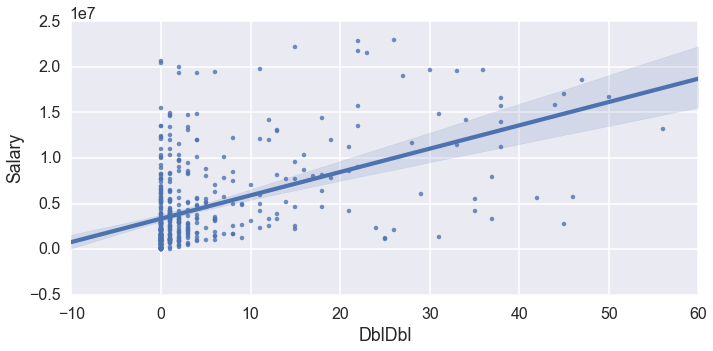

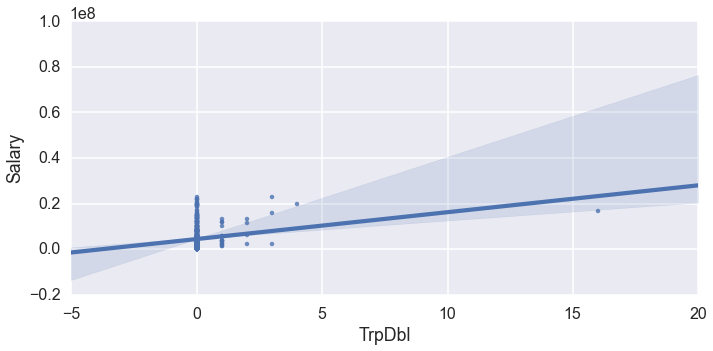

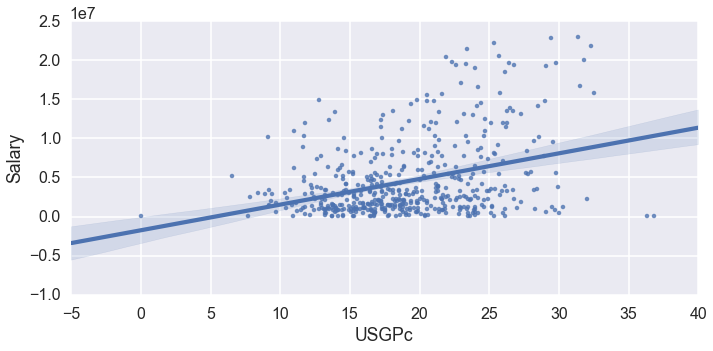

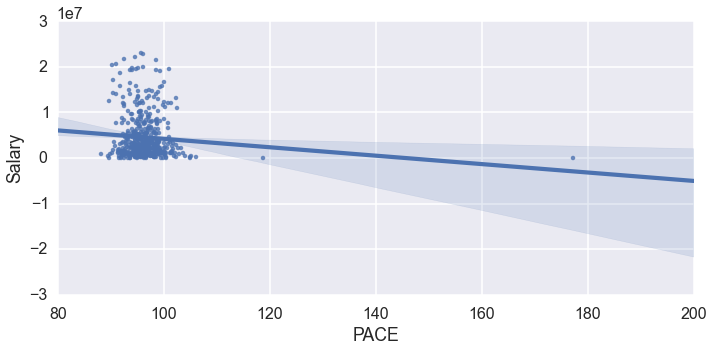

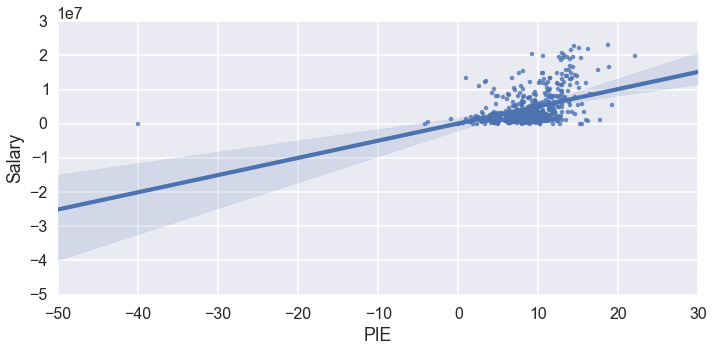

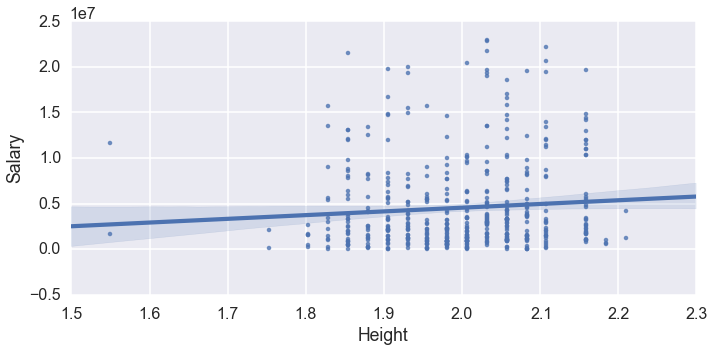

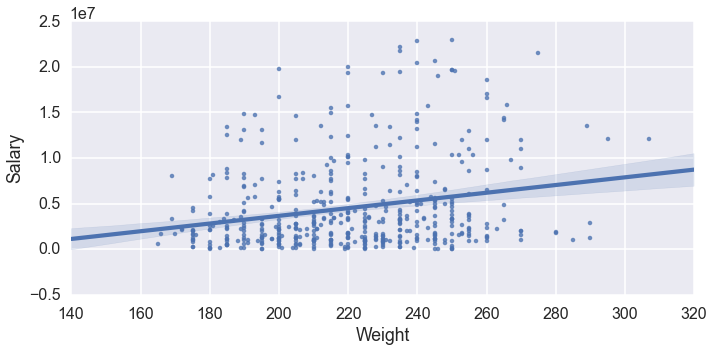

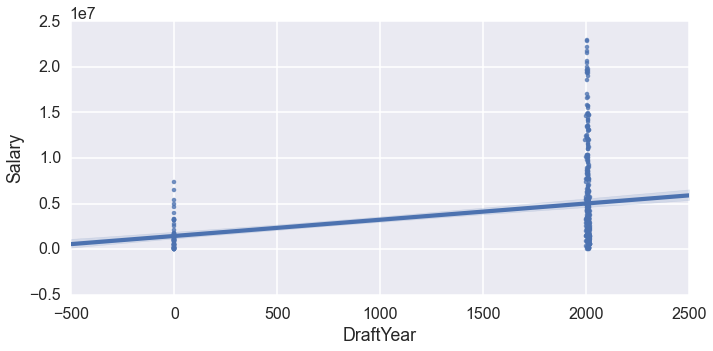

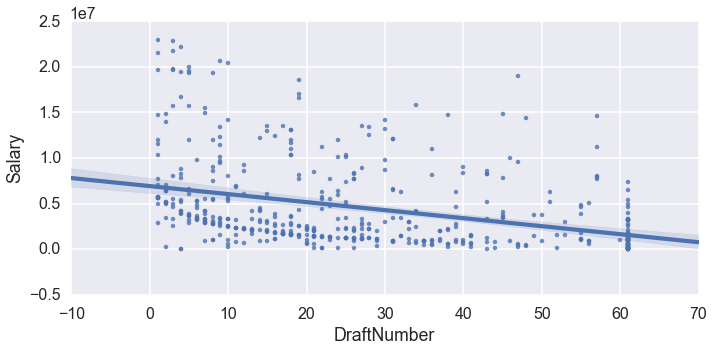

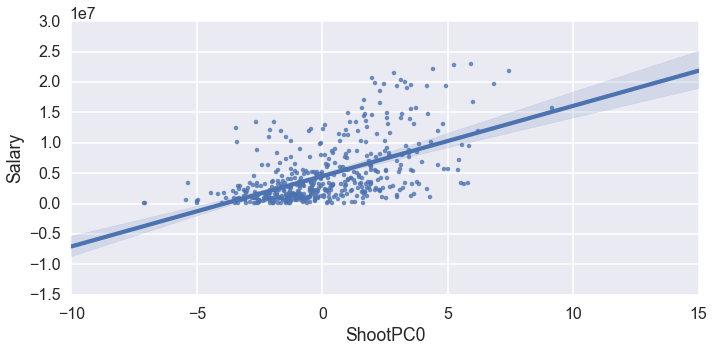

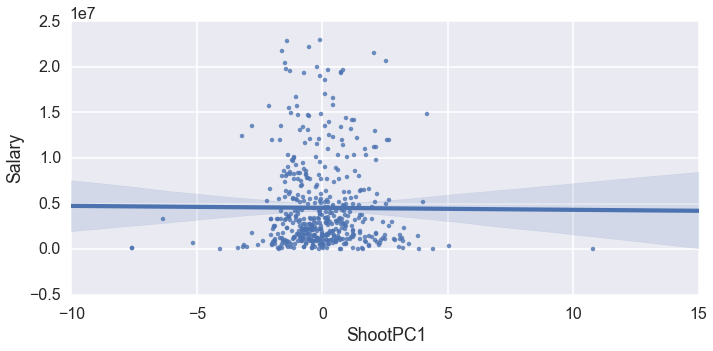

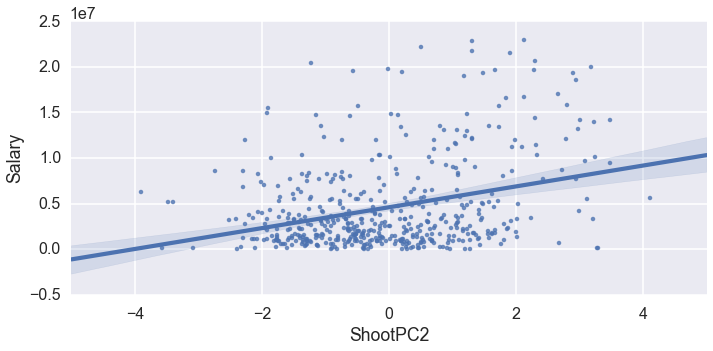

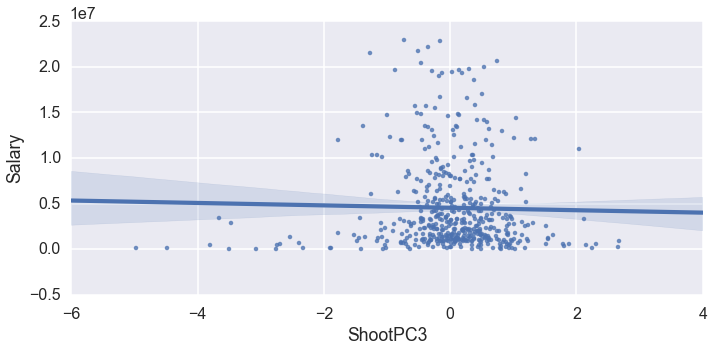

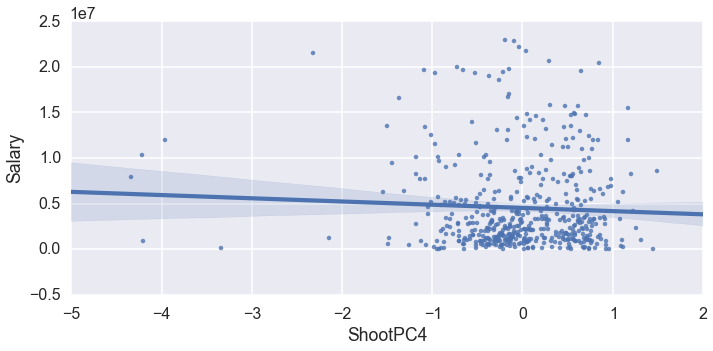

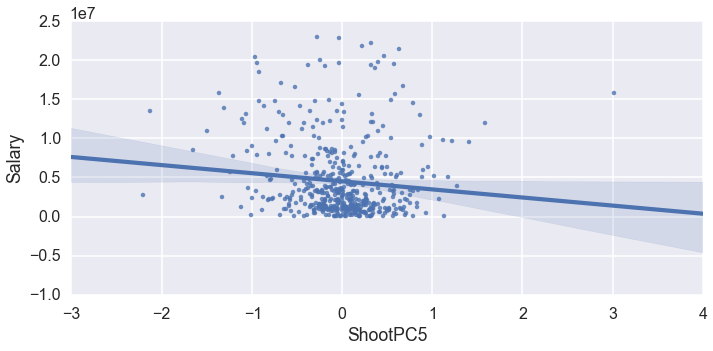

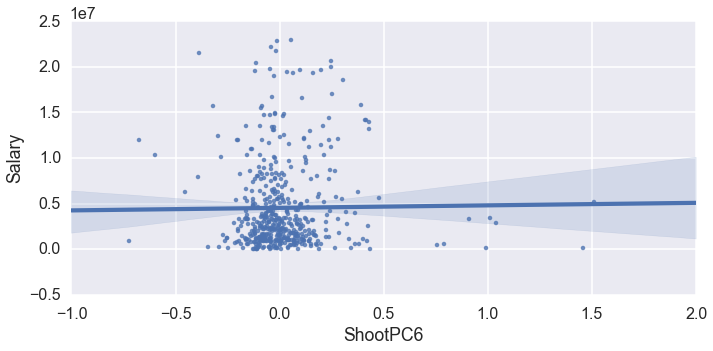

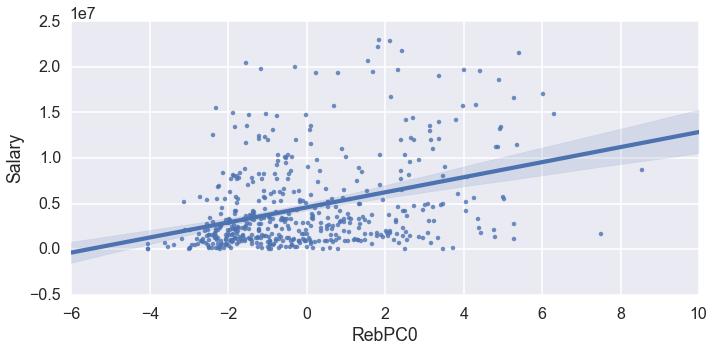

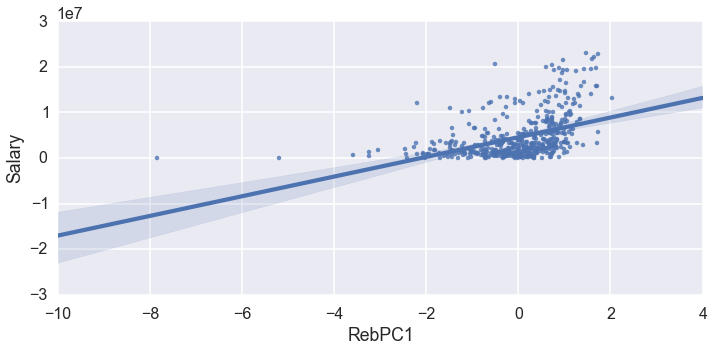

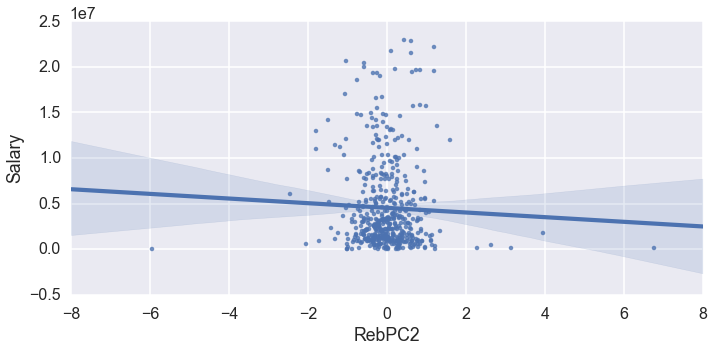

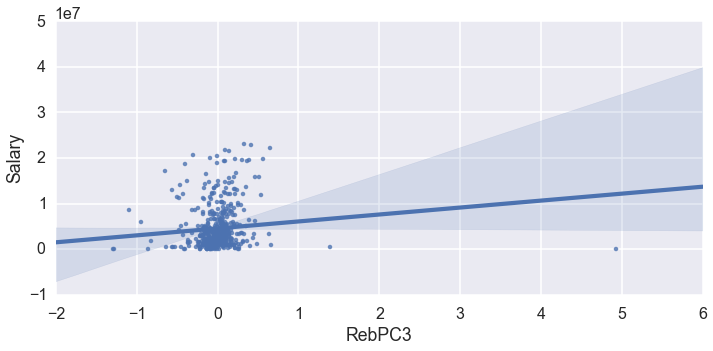

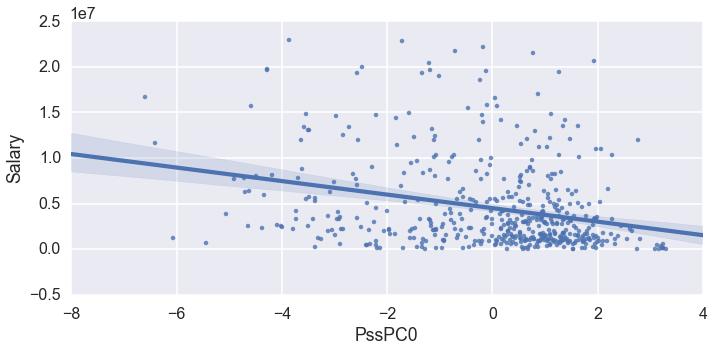

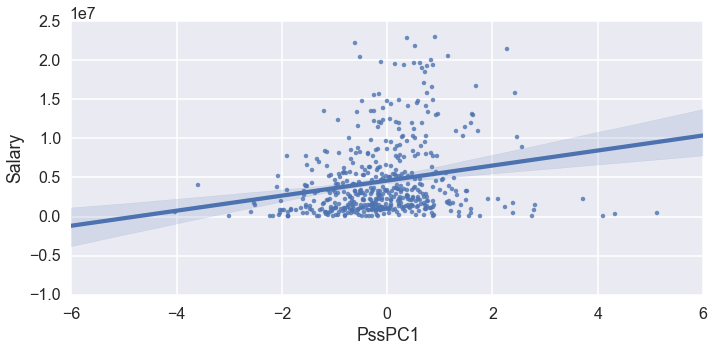

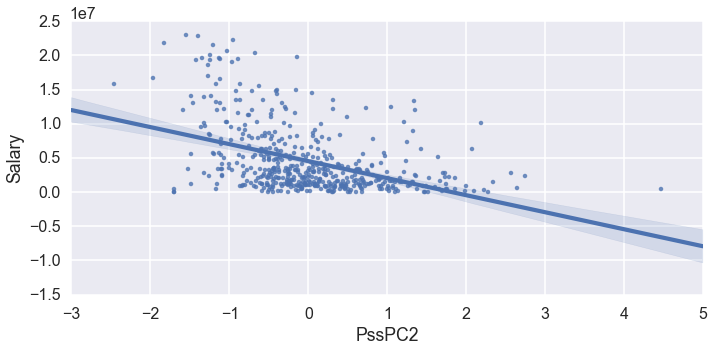

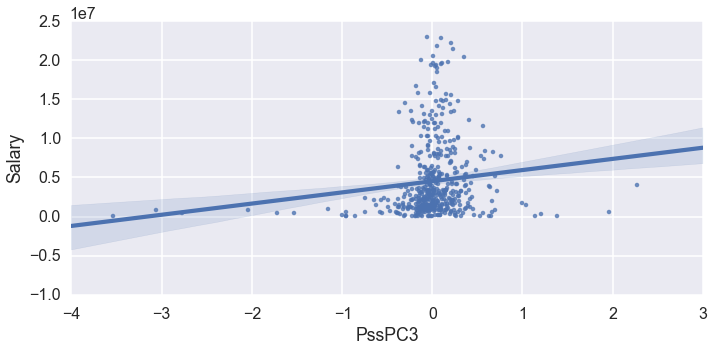

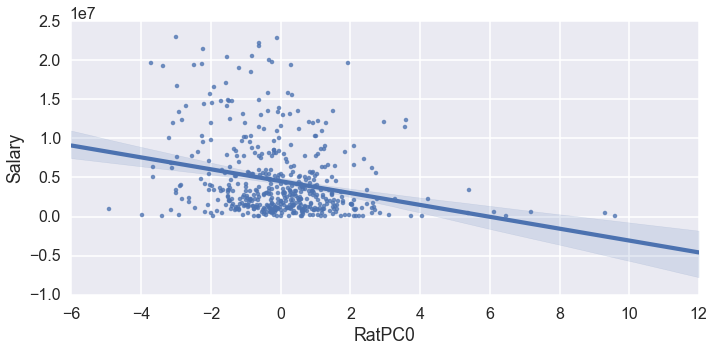

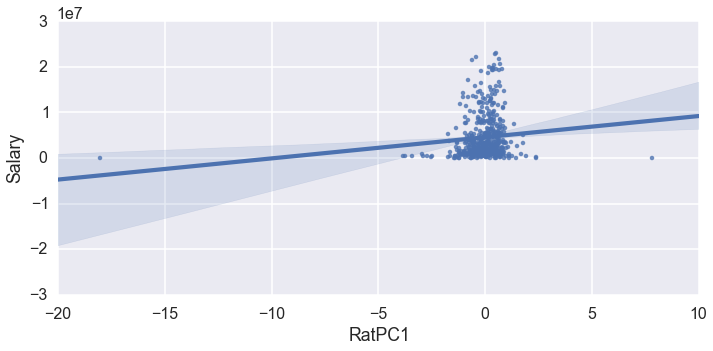

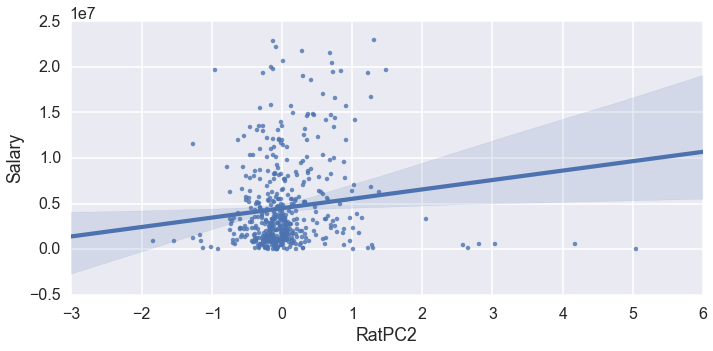

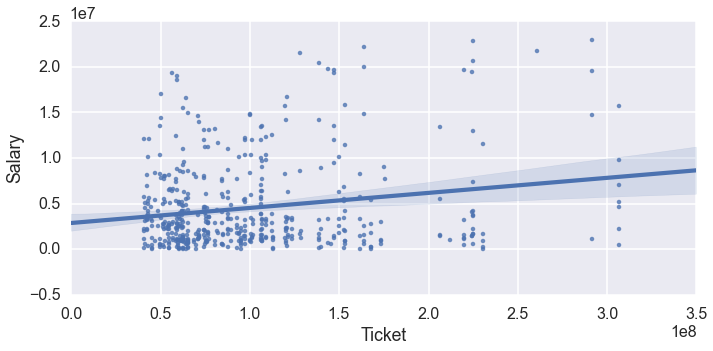

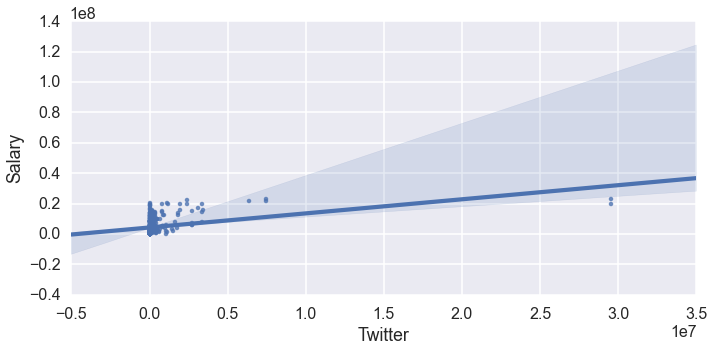

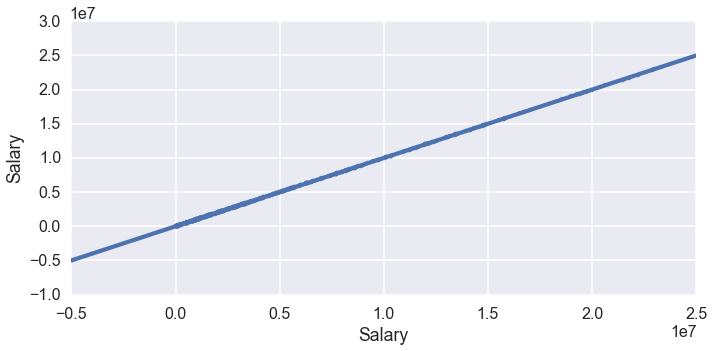

In [16]:
df_sample = df_try.copy()
df_sample = df_sample.sample(500)
for col in df_sample:
    with sns.plotting_context(context='poster'):
        sns.lmplot(col, "Salary", df_sample, aspect=2);

Still, there are no obvious pattern 

How about to assigning more weight (using power) and see if we can create new features

In [17]:
df_exp = df_try.copy()

for feat in df_exp:
    score =0
    for mod in range (20):
        df_exp["test"] = df_exp[feat] ** mod

        Colm = ""

        for col in df_exp:
            if col == "Salary":
                continue
            Colm  += col + " + "

        Colm = Colm[:-3]        

        results = ols('Salary ~ ' + Colm, df_exp).fit()
        if (results.rsquared - 0.60439510061962143) > 0.02:
            if score == 0:
                print feat
            print(mod, results.rsquared - 0.60439510061962143)
            score += 1
        del  df_exp["test"]
    if score != 0:
        print""

AGE
(5, 0.02026701034170697)
(6, 0.020701493295241513)
(7, 0.020847728272466282)
(8, 0.020740242019959054)

Twitter
(2, 0.022447610644087734)

Salary
(1, 0.39560489938037857)
(2, 0.3180734937448283)



It seems that creating another feature with different power did not increase the score much, this is an indicator that using polynomial regression may not be a good idea...

Let's move on

# Modelling

finding the best model and setting


In [18]:
df_try1 = df_try.copy()

# for noway in nope:
#     del df_try1 [noway]
    
X = df_try1.ix[:,:-3]
Y1 = df_try1.ix[:,-1]

## RandomForestRegressor

RFbestLeaf = 0
RFbestDepth = 0
RFbestScore = 0

for depth in range (15):
    for leaf in range (5):
        clf = RandomForestRegressor(n_estimators=50, max_depth=depth+1, min_samples_leaf=leaf+1, random_state=23)
        score = 0
        for i in range(10):
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)
            clf.fit(x_train, y_train)
            score += clf.score(x_test, y_test)
        if score > RFbestScore:
            RFbestScore = score
            RFbestLeaf = leaf + 1
            RFbestDepth = depth + 1

print "RandomForestRegressor"
print "Score:", RFbestScore/10
print "minimum leaf in best RF model " + str(RFbestLeaf)
print "maximum depth in best RF model " + str(RFbestDepth)

RandomForestRegressor
Score: 0.654404420186
minimum leaf in best RF model 1
maximum depth in best RF model 12


In [19]:

## ExtraTreesRegressor

RFbestLeaf = 0
RFbestDepth = 0
RFbestScore = 0

for depth in range (15):
    for leaf in range (5):
        clf = ExtraTreesRegressor(n_estimators=50, max_depth=depth+1, min_samples_leaf=leaf+1, random_state=23)
        score = 0
        for i in range(10):
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)
            clf.fit(x_train, y_train)
            score += clf.score(x_test, y_test)
        if score > RFbestScore:
            RFbestScore = score
            RFbestLeaf = leaf + 1
            RFbestDepth = depth + 1

print "ExtraTreesRegressor"
print "Score:", RFbestScore/10
print "minimum leaf in best ET model " + str(RFbestLeaf)
print "maximum depth in best ET model " + str(RFbestDepth)


ExtraTreesRegressor
Score: 0.665994674788
minimum leaf in best ET model 4
maximum depth in best ET model 12


In [20]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

df_base = df_try.copy()
X = df_base.ix[:,:-1]
Y = df_base.ix[:,-1]

results = []

for alpha in [0, 0.1,1,2,5,10,20,50,100,200,500,1000]:
    ridge = Ridge(alpha=alpha)
    
    ridge.fit(X, Y)
    
    score = ridge.score(X, Y)
    
    results.append((alpha, score))

for result in results:
    print result[0], ' : ', result[1]

0  :  0.604394700436
0.1  :  0.604394566009
1  :  0.604383938135
2  :  0.604360015576
5  :  0.604264447627
10  :  0.604100174733
20  :  0.603782814208
50  :  0.602707629115
100  :  0.600637324206
200  :  0.596611141489
500  :  0.587779840068
1000  :  0.578681398562


In [21]:

results = []

for alpha in [0, 0.1,1,2,5,10,20,50,100,200,500,1000]:
    ridge = ElasticNet(alpha=alpha)
    
    ridge.fit(X, Y)
    
    score = ridge.score(X, Y)
    
    results.append((alpha, score))

for result in results:
    print result[0], ' : ', result[1]

/home/vagrant/.anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/home/vagrant/.anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:432: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)


0  :  0.604394700436
0.1  :  0.601481598054
1  :  0.581838866251
2  :  0.571225792889
5  :  0.55326771545
10  :  0.536990672124
20  :  0.517912617966
50  :  0.485343087029
100  :  0.455008556642
200  :  0.421570946161
500  :  0.374093333039
1000  :  0.337447823022


/home/vagrant/.anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


As Seen from the result, random forest regressor and extra trees regressor beat the base classifier, and the best setting lies in high depth and low min leaf.

Additionally, ElasticNet and Ridge regression did not give a good score, which may suggest that simple linear regression is more suitable.

# Model building


Let's use ExtraTreesRegressor then

In [22]:
## ExtraTreesRegressor
X = df_try1.ix[:,:-3]
Y = df_try1.ix[:,-1]

ETbestLeaf = 3
ETbestDepth = 12
score = 0
Models = []
totalmodel = 100

for i in range(totalmodel):    
    clf = ExtraTreesRegressor(n_estimators=50, max_depth=ETbestDepth, min_samples_leaf=ETbestLeaf, random_state=23)    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)
    clf.fit(x_train, y_train)
    score += clf.score(x_test, y_test)
    
    Models.append(clf)

print score/totalmodel

0.643839697271


In [23]:
def predict(X,Models):
    tempSal = pd.DataFrame();
    tempSal["Salary"] = Models[0].predict(X)
    for model in range(1,len(Models)):
        tempSal["Salary"] = tempSal["Salary"] + Models[model].predict(X)
    
    return tempSal["Salary"].apply(lambda x : x/len(Models))
    

In [24]:
# (Models[0].predict(X.ix[2]))


predict(X.ix[2:3],Models)

0     510577.424520
1    2059563.203487
Name: Salary, dtype: float64

# Let's Explore and play with the model

In [56]:
# Base
df_base = df_try2.copy()
X = df_base.ix[:,:-3]
Y = df_base.ix[:,-1]

clf =  LinearRegression(fit_intercept=True, normalize=False, copy_X=True)
clf.fit(X,Y)
print clf.score(X,Y)

df_change = df_try.copy()

result = clf.predict(X)

0.596219870842


In [57]:
# Add some team ticket sales and official twitter account follower
df_base = df_try2.copy()
X = df_base.ix[:,:-1]
Y = df_base.ix[:,-1]

clf =  LinearRegression(fit_intercept=True, normalize=False, copy_X=True)
clf.fit(X,Y)
print clf.score(X,Y)

df_change = df_try.copy()

result = clf.predict(X)

0.608355321335


So, we can see here that including some "Economic data" did increase the score, this indicates that data such as social media followers and team sales (tickets/jersey sales) did account for the players salaries.

Which means that team pays player more depending on their ability to attract fans and boost sales.

While the ticketing sales shows that some teams did pays more due to their market. i.e LAC have cheaper ticket than LAL due to LAL have greater fan base. Also, NYK have bigger market and richer fans (New Yorker...), while MIN have smaller market.

Thus, it is expected that on average, MIN player are paid lower than NYK players.

In [65]:
for idx,feat in enumerate(X):
    print feat, clf.coef_[idx]
    
# Add some team ticket sales and official twitter account follower
df_base = df_try.copy()
X = df_base.ix[:,:-1]
Y = df_base.ix[:,-1]

clf =  LinearRegression(fit_intercept=True, normalize=False, copy_X=True)
clf.fit(X,Y)

print""
for idx,feat in enumerate(X):
    print feat, clf.coef_[idx]

AGE 260738.567548
W -11838.9187808
L -11909.1965229
FGM 598631.401105
FGA -8960.95165756
FGPc -7752.81652133
ThreePM -2202681.0372
ThreePA 665881.066966
ThreePPc 7744.11423598
FTM 508500.001031
FTA -109656.759205
FTPc 2543.59381836
OREB -1191922.3757
DREB -718112.371929
REB 1514068.22054
AST 718114.315779
TOV 745013.224736
STL -831423.587158
BLK 226301.003538
PF -1295825.84937
DblDbl -41775.9420063
TrpDbl -322681.661967
PTS 91991.1921387
PlsMns 229067.268113
OffRtg 305408.62048
DefRtg -295403.845223
NetRtg -333240.425394
ASTPc -54443.9728564
ASTTORtr -73326.0626989
ASTRatio 23541.8659056
OREBPc 148863.523989
DREBPc 84703.4722938
REBPc -255999.639915
TORatio -19287.9171606
eFGPc 39948.0931407
TSPc -18006.040916
USGPc 29520.7998984
PACE -718.63048785
PIE -165514.596823
Height 1741242.35198
Weight 20645.0682116
DraftYear 154.785180309
DraftNumber -21141.3739912
Twitter 0.348182132002
Ticket 0.00278615503833

AGE 261029.451337
W -12146.8490407
L -12151.7066809
STL -643052.062267
BLK 175709

This shows the importance of the features, we can see that some of the coefficients are not making sense...

But generally, the older/taller the player, the higher their salary.. (bullshit, of course experienced player are paid higher, and taller player are always at premium)

on average, one rebound per game are worth 1.5M
one points are worth 92K, even if you have 20 point per game, this is just 1.8M ... 2 rebound per game are even higher
one assist are worht 700K wow

It's weird that Steal have minus coefficient, and Block didn't have high coefficient. So defence are not important in NBA? ( salary wise). Now it makes sense why player with high offensive firepower have high salary.

No wonder they said teams that win the rebound battle win the championship. 1.5M ....

Now, let's see the distribution of salary, predicted salary and their differences

In [66]:
df_base = df_try.copy()
X = df_base.ix[:,:-3]
Y = df_base.ix[:,-1]

SalaryScore = pd.DataFrame()
SalaryScore["PredictSalary"] = predict(X,Models)
SalaryScore["Salary"] = df_try["Salary"]-SalaryScore["PredictSalary"]
# for i in range(1600):
#     SalaryScore["Salary"][i] -= predict(X.ix[i],Models)


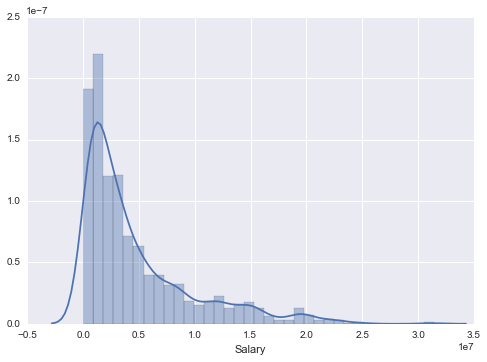

In [31]:
ax = sns.distplot(df_try["Salary"])

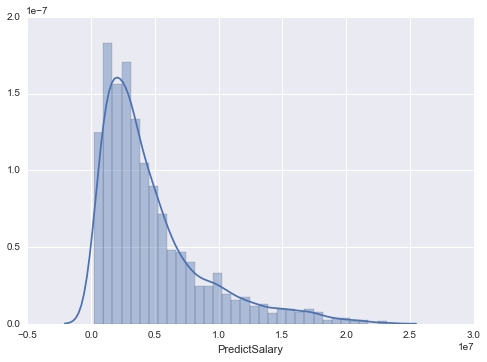

In [32]:
ax = sns.distplot(SalaryScore["PredictSalary"])

In [33]:
print "Mean \t",SalaryScore["PredictSalary"].mean()
print "Median \t",SalaryScore["PredictSalary"].median()

Mean 	4729133.84418
Median 	3390527.34754


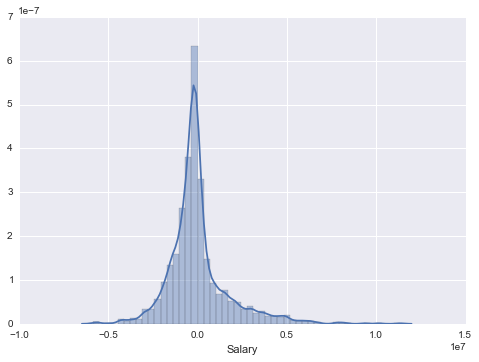

In [34]:
ax = sns.distplot(SalaryScore["Salary"])

In [35]:
print "Mean \t",SalaryScore["Salary"].mean()
print "Median \t",SalaryScore["Salary"].median()

Mean 	-3122.64032001
Median 	-224768.895539


Not shockingly ... it follows a normal distribution.

As a manager, if you want to get the gold ring, you might want to hire more players on the left side. With some super star that maybe land in the right side

but if you want to attract sales, you probably want to research how much extra profit you can gain by getting a player, then find out the player's performance's value and compare them to see wheter it is worth it.

Let's find the most "overpaid" and "underpaid" players

In [36]:
# Most expensive player, by performance
maxSal = SalaryScore["PredictSalary"].max()
index = SalaryScore["Salary"].loc[SalaryScore["PredictSalary"] == maxSal].index
index = index[0]
df["Player"][index]

'Kobe Bryant12-13'

In [37]:
# Most overpaid
maxSal = SalaryScore["Salary"].max()
index = SalaryScore["Salary"].loc[SalaryScore["Salary"] == maxSal].index
index = index[0]
df["Player"][index]

'Kobe Bryant13-14'

In [38]:
# Most underpaid
maxSal = SalaryScore["Salary"].min()
index = SalaryScore["Salary"].loc[SalaryScore["Salary"] == maxSal].index
index = index[0]
df["Player"][index]

'Michael Beasley15-16'



Now, how to find the value of certain players?
Let's play around here

In [39]:
#  first, we define a function that print out playerss salary/predicted and difference

def findHisOverRatedNess(Player):
    print Player
    index = SalaryScore["Salary"].loc[df['Player'] == Player].index
    index = index[0]
    print "Actual Salary ",df_try["Salary"][index]
    print "Predicted Salary ",SalaryScore["PredictSalary"][index]
    print "Salary Difference ",SalaryScore["Salary"][index]
    if SalaryScore["Salary"][index] > 1000000:
        print "overrated"
    elif SalaryScore["Salary"][index] < -1000000:
        print "underated"
    else:
        print "so so"
    print""
#     return(SalaryScore["Salary"][df[df.Player == Player+Year].index.tolist()])

In [71]:
findHisOverRatedNess("Kobe Bryant15-16")
findHisOverRatedNess("Kobe Bryant14-15")
findHisOverRatedNess("Kobe Bryant13-14")
findHisOverRatedNess("Kobe Bryant12-13")
findHisOverRatedNess("Carmelo Anthony14-15")
findHisOverRatedNess("Kevin Durant14-15")
findHisOverRatedNess("Russell Westbrook14-15")
findHisOverRatedNess("James Harden14-15")
findHisOverRatedNess("Jeremy Lin14-15")

print "Cleveland Cavaliers"
findHisOverRatedNess("Channing Frye15-16")
findHisOverRatedNess("Iman Shumpert15-16")
findHisOverRatedNess("J.R. Smith15-16")
findHisOverRatedNess("James Jones15-16")
findHisOverRatedNess("Joe Harris15-16")
findHisOverRatedNess("Jordan McRae15-16")
findHisOverRatedNess("Kevin Love15-16")
findHisOverRatedNess("Kyrie Irving15-16")
findHisOverRatedNess("LeBron James15-16")
findHisOverRatedNess("Matthew Dellavedova15-16")
findHisOverRatedNess("Mo Williams15-16")
findHisOverRatedNess("Richard Jefferson15-16")
findHisOverRatedNess("Sasha Kaun15-16")
findHisOverRatedNess("Timofey Mozgov15-16")
findHisOverRatedNess("Tristan Thompson15-16")

print "San Antonio Spurs"
findHisOverRatedNess("Andre Miller15-16")
findHisOverRatedNess("Boban Marjanovic15-16")
findHisOverRatedNess("Boris Diaw15-16")
findHisOverRatedNess("Danny Green15-16")
findHisOverRatedNess("David West15-16")
findHisOverRatedNess("Jonathon Simmons15-16")
findHisOverRatedNess("Kawhi Leonard15-16")
findHisOverRatedNess("Kawhi Leonard14-15")
findHisOverRatedNess("Kawhi Leonard13-14")
findHisOverRatedNess("Kevin Martin15-16")
findHisOverRatedNess("Kyle Anderson15-16")
findHisOverRatedNess("LaMarcus Aldridge15-16")
findHisOverRatedNess("Manu Ginobili15-16")
findHisOverRatedNess("Matt Bonner15-16")
findHisOverRatedNess("Rasual Butler15-16")
findHisOverRatedNess("Tim Duncan15-16")
findHisOverRatedNess("Tony Parker15-16")

print "Golden State Warriors"
findHisOverRatedNess("Anderson Varejao15-16")
findHisOverRatedNess("Andre Iguodala15-16")
findHisOverRatedNess("Andre Iguodala14-15")
findHisOverRatedNess("Andre Iguodala13-14")
findHisOverRatedNess("Andrew Bogut15-16")
findHisOverRatedNess("Brandon Rush15-16")
findHisOverRatedNess("Draymond Green15-16")
findHisOverRatedNess("Festus Ezeli15-16")
findHisOverRatedNess("Harrison Barnes15-16")
findHisOverRatedNess("Ian Clark15-16")
findHisOverRatedNess("James Michael McAdoo15-16")
findHisOverRatedNess("Kevon Looney15-16")
findHisOverRatedNess("Klay Thompson15-16")
findHisOverRatedNess("Leandro Barbosa15-16")
findHisOverRatedNess("Marreese Speights15-16")
findHisOverRatedNess("Shaun Livingston15-16")
findHisOverRatedNess("Stephen Curry15-16")
findHisOverRatedNess("Stephen Curry14-15")
findHisOverRatedNess("Stephen Curry13-14")
findHisOverRatedNess("Stephen Curry12-13")


Kobe Bryant15-16
Actual Salary  25000000.0
Predicted Salary  16897632.1966
Salary Difference  8102367.80341
overrated

Kobe Bryant14-15
Actual Salary  23547000.0
Predicted Salary  22679523.5243
Salary Difference  867476.475722
so so

Kobe Bryant13-14
Actual Salary  31001973.49
Predicted Salary  19649702.6063
Salary Difference  11352270.8837
overrated

Kobe Bryant12-13
Actual Salary  31458780.57
Predicted Salary  23171015.6944
Salary Difference  8287764.87565
overrated

Carmelo Anthony14-15
Actual Salary  22503317.8
Predicted Salary  20669005.9259
Salary Difference  1834311.87411
overrated

Kevin Durant14-15
Actual Salary  19033615.25
Predicted Salary  17691935.4227
Salary Difference  1341679.82735
overrated

Russell Westbrook14-15
Actual Salary  15750500.12
Predicted Salary  15469022.3341
Salary Difference  281477.785943
so so

James Harden14-15
Actual Salary  14758301.69
Predicted Salary  14571245.008
Salary Difference  187056.682046
so so

Jeremy Lin14-15
Actual Salary  8391395.292
P

Kobe are overpaid.. common sense lah. But he have a HUGE fan base, that explains
He also have high predicted salary, the reason, well, he is the "Main characters" of the Lakers, thus he have more chance to make big plays, shot more, and no one would dare to complain.

Carmelo are overpaid by just 1M, considering he is also the Kobe of Knicks (but he sucks...the team too, in fact, the team perform well without him...).

J lin are overated, of course, considering the Linsanity are short-lived.

Looking at the Cavs, it is very surprising that LBJ are just overpaid by 1.5M, considering he is the best player on earth currently, and Cleveland ticket sales and prices actually skyrocketted after his return to Cavs. (The cavs have far lower win rate without James on floor)
Kylie and Kevin are widely considered to be overpriced too. Kylie is a bit of ballhog... While Kevin is considered to be overpaid by experts (and should be traded/waived when possible)

For the Spurs, note the big jump from being underated by 4 Millions to overpriced by 4 Millions.
This guy are the Final MVP and NBA champion on 13-14 season, (his breakthrough season) noted for defending LBJ, the best player on earth successfully.
while on 14-15 season, he won the Defensive players of the years.
but why the jump occured on 15-16? Because his contract are renewed on 15-16 season..haha,
Note the predicted price though

Among the three old man of Spurs, only Tony Parker are overpaid(Being the youngest and smartest), while Ginobili and Duncan are way underpaid (as they are aging, however, they can still put up a performance).

For the Warriors, Andre are overated.... well, he shut down LBJ and was pivotal in Warriors championship runs.
Note that Chef Curry, the crazy 3 point machine, are underated in all 4 season, because, his contracts start on 12 and end of 16-17. and his breakout years started on 12-13 season.

In fact, many experts said that Curry were injury prone, and thus is a risky sign at begining of 12-13 season, this explained his cheap contract. So Golden State will still have a cheap superstar until end of 16-17 season, where we expect his salary to sky rocket...

Now, some actionable insight to NBA managers. Free Agency!

While we didn't list everybody on free agency, here are some underrated players managers can consider on next free agency: (Assuming their salary will not jump too much)

In [76]:
findHisOverRatedNess("Andre Drummond15-16")
findHisOverRatedNess("DeMar DeRozan15-16")
findHisOverRatedNess("Pau Gasol15-16")
findHisOverRatedNess("Al Horford15-16")
findHisOverRatedNess("Mike Conley15-16")
findHisOverRatedNess("Dirk Nowitzki15-16")
findHisOverRatedNess("Rajon Rondo15-16")

Andre Drummond15-16
Actual Salary  3272091.0
Predicted Salary  5005705.28705
Salary Difference  -1733614.28705
underated

DeMar DeRozan15-16
Actual Salary  9500000.0
Predicted Salary  10972556.5795
Salary Difference  -1472556.57954
underated

Pau Gasol15-16
Actual Salary  7448760.0
Predicted Salary  11030306.2434
Salary Difference  -3581546.2434
underated

Al Horford15-16
Actual Salary  12000000.0
Predicted Salary  12206939.2013
Salary Difference  -206939.201311
so so

Mike Conley15-16
Actual Salary  9588426.0
Predicted Salary  9797695.40268
Salary Difference  -209269.402684
so so

Dirk Nowitzki15-16
Actual Salary  8333334.0
Predicted Salary  12281352.28
Salary Difference  -3948018.28004
underated

Rajon Rondo15-16
Actual Salary  9500000.0
Predicted Salary  10266258.2108
Salary Difference  -766258.210823
so so



# Let's play play

In [49]:
# This guy got 33 million
# 48,751,794 in today value

MichaelJordan = pd.read_csv(DATA_FOLDER+'play.csv')

del MichaelJordan["Player"]
del MichaelJordan["TEAM"]
del MichaelJordan["College"]
del MichaelJordan["Country"]

MichaelJordan["OffRtg"] = MichaelJordan["OffRtg"] - 100
MichaelJordan["DefRtg"] = MichaelJordan["DefRtg"] - 100

# Delete redundant stuffs
del MichaelJordan["GP"]
del MichaelJordan["MIN"]
del MichaelJordan["Ticket"]
del MichaelJordan["Twitter"]


# Shooting related
df_MJShoot = pd.DataFrame()
df_MJShoot["FGA"] = MichaelJordan["FGA"]
df_MJShoot["FGM"] = MichaelJordan["FGM"] 
df_MJShoot["FGPc"] = MichaelJordan["FGPc"]
df_MJShoot["FTM"] = MichaelJordan["FTM"]
df_MJShoot["FTA"] = MichaelJordan["FTA"]
df_MJShoot["FTPc"] = MichaelJordan["FTPc"]
df_MJShoot["ThreePA"] = MichaelJordan["ThreePA"]
df_MJShoot["ThreePM"] = MichaelJordan["ThreePM"]
df_MJShoot["ThreePPc"] = MichaelJordan["ThreePPc"]
df_MJShoot["eFGPc"] = MichaelJordan["eFGPc"]
df_MJShoot["TSPc"] = MichaelJordan["TSPc"] 
df_MJShoot["PTS"] = MichaelJordan["PTS"]
df_MJShoot = (df_MJShoot - df_normShoot.mean()) / df_normShoot.std()

labels = ['pc'+ str(pc) for pc in range(0,12)]
df_pca = pd.DataFrame(pcaSht.transform(df_MJShoot), columns=labels)

# var = pcaSht.explained_variance_ratio_ / max(pcaSht.explained_variance_)
# plt.plot(var);

del MichaelJordan["FGA"]
del MichaelJordan["FGM"] 
del MichaelJordan["FTM"]
del MichaelJordan["FTA"]
del MichaelJordan["PTS"]
del MichaelJordan["ThreePA"]
del MichaelJordan["ThreePM"]
del MichaelJordan["ThreePPc"]
del MichaelJordan["eFGPc"]
del MichaelJordan["TSPc"]
del MichaelJordan["FTPc"]
del MichaelJordan["FGPc"]

MichaelJordan["ShootPC0"] = df_pca["pc0"]
MichaelJordan["ShootPC1"] = df_pca["pc1"]
MichaelJordan["ShootPC2"] = df_pca["pc2"]
MichaelJordan["ShootPC3"] = df_pca["pc3"]
MichaelJordan["ShootPC4"] = df_pca["pc4"]
MichaelJordan["ShootPC5"] = df_pca["pc5"]
MichaelJordan["ShootPC6"] = df_pca["pc6"]

# Rebounding related
df_MJReb = pd.DataFrame()
df_MJReb["OREB"] = MichaelJordan["OREB"]
df_MJReb["DREB"] = MichaelJordan["DREB"] 
df_MJReb["OREBPc"] = MichaelJordan["OREBPc"]
df_MJReb["DREBPc"] = MichaelJordan["DREBPc"]
df_MJReb["REBPc"] = MichaelJordan["REBPc"]
df_MJReb["REB"] = MichaelJordan["REB"]

df_MJReb = (df_MJReb - df_normReb.mean()) / df_normReb.std()

labels = ['pc'+ str(pc) for pc in range(0,6)]
df_pca = pd.DataFrame(pcaReb.transform(df_MJReb), columns=labels)

del MichaelJordan["OREB"]
del MichaelJordan["DREB"] 
del MichaelJordan["OREBPc"]
del MichaelJordan["DREBPc"]
del MichaelJordan["REBPc"]
del MichaelJordan["REB"]

MichaelJordan["RebPC0"] = df_pca["pc0"]
MichaelJordan["RebPC1"] = df_pca["pc1"]
MichaelJordan["RebPC2"] = df_pca["pc2"]
MichaelJordan["RebPC3"] = df_pca["pc3"]

# Passing related
df_MJPss = pd.DataFrame()
df_MJPss["AST"] = MichaelJordan["AST"]
df_MJPss["TOV"] = MichaelJordan["TOV"] 
df_MJPss["ASTPc"] = MichaelJordan["ASTPc"]
df_MJPss["ASTRatio"] = MichaelJordan["ASTRatio"]
df_MJPss["ASTTORtr"] = MichaelJordan["ASTTORtr"]
df_MJPss["TORatio"] = MichaelJordan["TORatio"]

df_MJPss = (df_MJPss - df_normPss.mean()) / df_normPss.std()

labels = ['pc'+ str(pc) for pc in range(0,6)]
df_pca = pd.DataFrame(pcaPss.transform(df_MJPss), columns=labels)

del MichaelJordan["AST"]
del MichaelJordan["TOV"] 
del MichaelJordan["ASTPc"]
del MichaelJordan["ASTRatio"]
del MichaelJordan["ASTTORtr"]
del MichaelJordan["TORatio"]

MichaelJordan["PssPC0"] = df_pca["pc0"]
MichaelJordan["PssPC1"] = df_pca["pc1"]
MichaelJordan["PssPC2"] = df_pca["pc2"]
MichaelJordan["PssPC3"] = df_pca["pc3"]

# Rating related
df_MJRat = pd.DataFrame()
df_MJRat["NetRtg"] = MichaelJordan["NetRtg"]
df_MJRat["OffRtg"] = MichaelJordan["OffRtg"] 
df_MJRat["DefRtg"] = MichaelJordan["DefRtg"]
df_MJRat["PlsMns"] = MichaelJordan["PlsMns"]

df_MJRat = (df_MJRat - df_normRat.mean()) / df_normRat.std()

labels = ['pc'+ str(pc) for pc in range(0,4)]
df_pca = pd.DataFrame(pcaRat.transform(df_MJRat), columns=labels)

del MichaelJordan["NetRtg"]
del MichaelJordan["OffRtg"] 
del MichaelJordan["DefRtg"]
del MichaelJordan["PlsMns"]

MichaelJordan["RatPC0"] = df_pca["pc0"]
MichaelJordan["RatPC1"] = df_pca["pc1"]
MichaelJordan["RatPC2"] = df_pca["pc2"]


In [73]:
MJSal = predict(MichaelJordan,Models)
print "MJ's should have this salary ", MJSal[0]
print "So he is overrated by ", 48751794 - MJSal[0]


MJ's should have this salary  14342705.4175
So he is overrated by  34409088.5825


hmmm....

Its hard to compare a 1998 player with 2016 standard. Reason:
* everything is advanced now.
* NBA players have better access to trainer and tech
* MJ 1998 salary are the highest in NBA history, even before inflation adjustment, many reseach paper always remove his data (outliers)

Also, we are dealing with the basketball god,
* of course he is overrated (salary wise)
* MJ's Physical prime was in 1991-92, (first three peat), in which he have better numbers, but only paid 4M ... (6-7M when adjusted by inflation, which makes him underpaid if his stats are actually better than 97-98 version.
* at 97-98 season, he is in his second three peat, everyone know him, thus Chicago can charge premiums in ticket and jersey sales, this explains the "non-performance" super overpaid part of his salary.
* we dont have MJ stat on 91-92, sadly.


In [51]:
teams = set(df["TEAM"])
lol = {}
count = {}
for i in teams:
    lol[i]=0
    count[i]=0

for i in range(1600):
    lol[df["TEAM"][i]] += SalaryScore["Salary"][i]
    count[df["TEAM"][i]] +=1
    
for idx in teams:
    lol[idx] = lol[idx] / count[idx]

In [72]:
# Avergae salary difference per team
lol

{'ATL': -424108.53755335807,
 'BKN': 713457.57091728866,
 'BOS': 181342.24596765262,
 'CHA': 21605.979016321606,
 'CHI': -212203.83183062967,
 'CLE': 132813.94355780355,
 'DAL': -136861.02599998389,
 'DEN': -137711.03478865285,
 'DET': 347394.29091843707,
 'GSW': 289531.53269753547,
 'HOU': -186284.36032819308,
 'IND': 80537.086563512392,
 'LAC': -156746.53375744208,
 'LAL': 575928.42625046289,
 'MEM': -39841.014215799361,
 'MIA': -15186.300943129871,
 'MIL': 62580.60848538937,
 'MIN': -151284.38952837265,
 'NOH': -150521.75108135925,
 'NYK': -47034.779225234925,
 'OKC': 121424.29697563495,
 'ORL': 21628.868677751929,
 'PHI': -390967.36524778919,
 'PHX': -288255.26154497958,
 'POR': -203447.59390451969,
 'SAC': -108755.10726752196,
 'SAS': -17549.760442674313,
 'TOR': 157141.89115632215,
 'UTA': -7800.2253614808033,
 'WAS': -17801.857988379921}

Frances commented that Spurs player are generally underrated as they played team basketball, (team plays over individual plays). 
The observation are valid due to SAS players are underpaid (underrated) on average. But they are a super good team (2014 champion)

From the Figure, we can see that Brooklyn players are the most overrated... considering their bad performance, hope that their ticket sales and jersey sales did make up for this.

LAL is also generally overpaid, due to KOBE overpaid by overpaid by 8 to 11 millions. Thus the lakers can only sign cheap players..enabling the KOBE to run his show more, and geting good stats (still overpaid, tho)

# Conclusion 

For BKN (#14 on eastern conference) and MIL (#12 on eastern conference) Team. Fire your hiring manager, or whoever make decision on player contracts. The team have bad performance, and I don't think they do good on sales.

For team manager and coaches: look out for the underrated players in the nest free agency!!!

Also, here's a tool to predict player worth, but we only account performance only.

Data Science wise:
* Seems like the Linear regression are better than Polynomial in this problems.
* Players performance can only explain 0.66 of their Salary, the remaining 0.33 is (possibly) the fans/profit the players can generate for their team.
* Feature engineering (pca and feature creation) didn't really work on improving the data.


Future ideas:
* Gather economic data, such as social media followers (facenbook) and activity for every players, team ticket and jersey sales, and see if the additional data increase the models' score.
* Is 0.66 the ceiling of Salary prediction if just performance data is used?
* find out if MJ are really overrated.
* Is there a way to create feature from the basics statistic data to improve the score?